# Intro

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from scipy import stats

import xarray as xa

from scipy.stats import t

import statsmodels.api as sm

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
import methods

In [5]:
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, 222-1)
ts


1.970756270488079

In [6]:
t_value = t.ppf(0.975, df=162-1)
t_value

1.974808091744976

In [7]:
all0205 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200207-200505.nc", engine='netcdf4')
all0508 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200506-200804.nc", engine='netcdf4')
all0811 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200805-201103.nc", engine='netcdf4')
all1114 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201104-201402.nc", engine='netcdf4')
all1417 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201403-201701.nc", engine='netcdf4')
all1821 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201702-201912.nc", engine='netcdf4')
all2123 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_202001-202211.nc", engine='netcdf4')
all2223 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_202212-202302.nc", engine='netcdf4')

In [8]:
var = "toa_lw"
alllw = xa.concat( [all0205[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all0508[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all0811[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1114[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1417[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1821[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all2123[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],], 
               dim='time')

In [9]:
var = "toa_sw"
allsw = xa.concat( [all0205[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all0508[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all0811[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1114[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1417[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1821[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all2123[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],], 
               dim='time')

In [10]:
#Gistemp Surface temp by lat, lon and time
#st_global_anom_raghu = xa.open_dataset("../daa/gistemp1200_GHCNv4_ERSSTv5.nc").sel(time=filtered_dates).tempanomaly
#gmst_anom_raghu = st_global_anom_raghu.mean(["lat", "lon"])
#gmst_anom_raghu 

In [11]:
#0
trop = slice(-30,30)
ragutime = slice('2002-07-15T00:00:00.000000000',\
                 '2020-12-15T00:00:00.000000000' )
itcz = slice(-0.5, 20.5) #slice(5,15)
trop = slice(-30,30)
wp = slice(120,160)
cp = slice(160,200)
ep = slice(210,260)
ocean_only = slice(120,260)

In [12]:
def total_feedback(area, K, gmst):
    """ Computes total feedback given a CTP-tau feedback object.
    Parameters:
    ----------
    area: xa.DataArray
        area
    K: xa.DataArray
        kernel
    gmst: numpy.Array
        GMST mean 
        
    Returns:
    -------
    feed_r, feed_std: tuple
        Total feedback and its standard error
    """
    cc_anom = area.groupby("time.month") - area.groupby("time.month").mean("time")
    R = K.mean("time")*cc_anom
    R_mean = R.mean(["lat"]) #weighted(weights=weights).

    feed =  np.zeros([7,6])
    feed_st = np.zeros([7,6])

    for od in [0,1,2,3,4,5]:
        for p in [0,1,2,3,4,5,6]:
            bints = R_mean.sel(press=p, opt=od)
            net_regress = stats.linregress(gmst, bints)
            feed[p, od] = net_regress.slope
            feed_st[p, od] = net_regress.stderr

    feed_r = xa.DataArray(feed, 
                        coords={"press": R_mean.press, "opt":R_mean.opt, 
                            },
                    )
    
    feed_std = xa.DataArray(feed_st, 
                        coords={"press": R_mean.press, "opt":R_mean.opt, 
                            },
                    )
    
    return feed_r, feed_std

# Tropics

## Kernels

In [13]:
RclrLW_trop = alllw.sel(lat=trop,time=ragutime).toa_lw_clr_mon.mean(["lon"])
RovcLW_trop = alllw.sel(lat=trop,time=ragutime).toa_lw_cldtyp_mon.mean(["lon"])
lwK_trop = (RclrLW_trop - RovcLW_trop)/100

In [14]:
RclrSW_trop = allsw.sel(lat=trop,time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_trop = allsw.sel(lat=trop,time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_trop = (RclrSW_trop - RovcSW_trop)/100

In [15]:
#1d
#If I dont mean over lon before, this will have loads of nans
K_trop = lwK_trop + swK_trop

Text(0.5, 1.0, 'c) Tropical-mean net kernel')

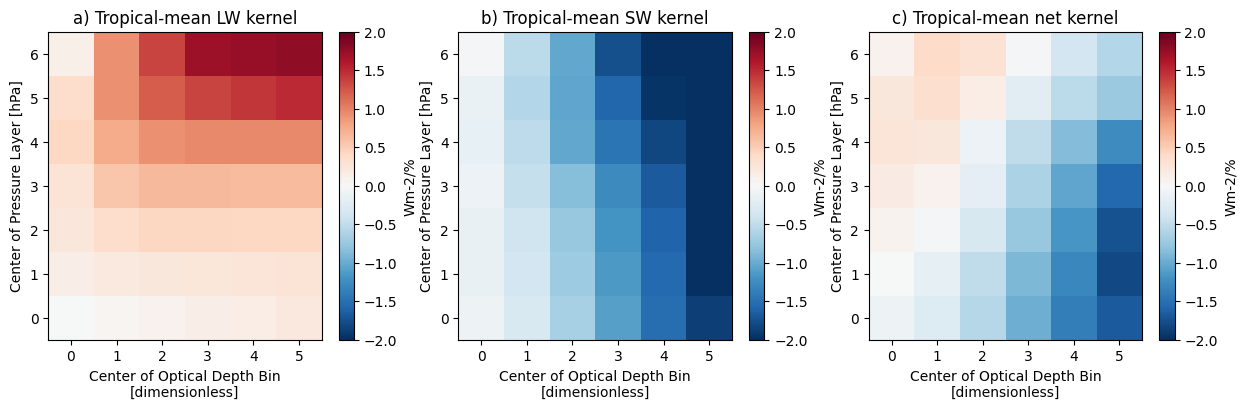

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwK_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) Tropical-mean LW kernel")
swK_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) Tropical-mean SW kernel")
K_trop.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) Tropical-mean net kernel")
#plt.savefig("kernels.png")

In [17]:
#Another way of testing if the kernels values are ok
p = np.array([1000.0 ,  800.0,  680,  560,  440, 310.0,  180,  10])
midpoints = [(p[i] + p[i -1])/2 for i in np.arange(len(p)) ]
midpoints

[505.0, 900.0, 740.0, 620.0, 500.0, 375.0, 245.0, 95.0]

Text(0.5, 1.0, 'Kernel values at misdpoint pressure bins')

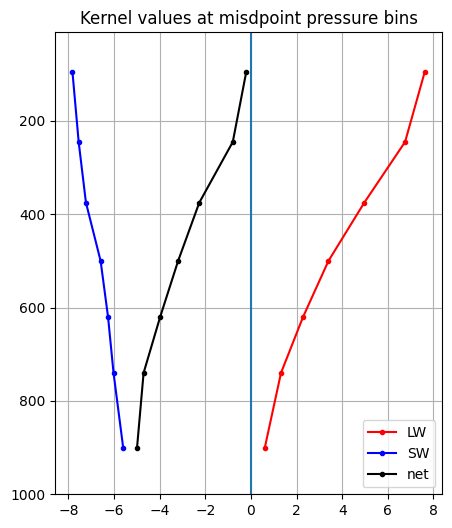

In [18]:
plt.figure(figsize=(5,6))
plt.plot(lwK_trop.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-r", label="LW")
plt.plot(swK_trop.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-b", label="SW")
plt.plot(K_trop.mean(["lat","time"]).sum("opt"), midpoints[1:], ".-k", label="net")
plt.gca().invert_yaxis()
plt.ylim(1000,10)
plt.vlines(0, ymin=1000, ymax=10)
plt.grid()
plt.legend()
plt.title("Kernel values at misdpoint pressure bins")
#plt.savefig("kernels_values.png")

In [19]:
#2
area_trop = alllw.cldarea_cldtyp_mon.sel(lat=trop, time=ragutime).mean("lon")
cc_trop_anom = area_trop.groupby('time.month')- area_trop.groupby('time.month').mean('time')

In [20]:
#3
#NOtice! If I mean over lon here rather than when calculating the kernels, the feedback values change slightly (further away than raghuraman's)
#IN the seconfnd 
lwR_trop = lwK_trop.mean("time")*cc_trop_anom
swR_trop = swK_trop.mean("time")*cc_trop_anom

In [21]:
# Rp = K_trop.sum("opt")*cc_trop_anom.sum("opt")
# Rp.sum("press").mean("lat")

# Rtau = K_trop.sum("press")*cc_trop_anom.sum("press")
# Rtau.sum("opt").mean("lat")

In [22]:
weights = np.cos(np.deg2rad(swR_trop.lat))
weights

<xarray.DataArray 'lat' (lat: 60)>
array([0.87035567, 0.87881714, 0.8870108 , 0.89493436, 0.90258527,
       0.9099613 , 0.9170601 , 0.9238795 , 0.9304176 , 0.9366722 ,
       0.9426415 , 0.94832367, 0.95371693, 0.95881975, 0.96363044,
       0.96814764, 0.9723699 , 0.976296  , 0.9799247 , 0.9832549 ,
       0.9862856 , 0.9890159 , 0.9914449 , 0.9935719 , 0.9953962 ,
       0.9969173 , 0.9981348 , 0.99904823, 0.99965733, 0.9999619 ,
       0.9999619 , 0.99965733, 0.99904823, 0.9981348 , 0.9969173 ,
       0.9953962 , 0.9935719 , 0.9914449 , 0.9890159 , 0.9862856 ,
       0.9832549 , 0.9799247 , 0.976296  , 0.9723699 , 0.96814764,
       0.96363044, 0.95881975, 0.95371693, 0.94832367, 0.9426415 ,
       0.9366722 , 0.9304176 , 0.9238795 , 0.9170601 , 0.9099613 ,
       0.90258527, 0.89493436, 0.8870108 , 0.87881714, 0.87035567],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    valid_range:    [-90.  90.]

In [23]:
#4
lwR_trop_mean = lwR_trop.mean(["lat"]) #.weighted(weights=weights)
swR_trop_mean = swR_trop.mean(["lat"]) #.weighted(weights=weights)

### GMST

In [24]:
#5
#Gistemp GMST anomalies
gmst1850 = pd.read_csv("../daa/GLB.Ts+dSST.csv", skiprows=[0])

gmst = gmst1850.loc[ gmst1850['Year'] >= 2002 ]
gmst = gmst.loc[ gmst['Year'] < 2021 ]
lista_gmst = gmst[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']].values.flatten().tolist()
#lista_gmst, len(lista_gmst)
lista_gmst[6:]
#NOT the same as meaqning across all the values, which gives:0.7340974 , 0.23327379, 0.95729756, 0.8614268 , 0.7519227... 
gmst_anom_raghu = np.array(lista_gmst[6:], dtype=np.float16)
gmst_anom_raghu.shape

(222,)

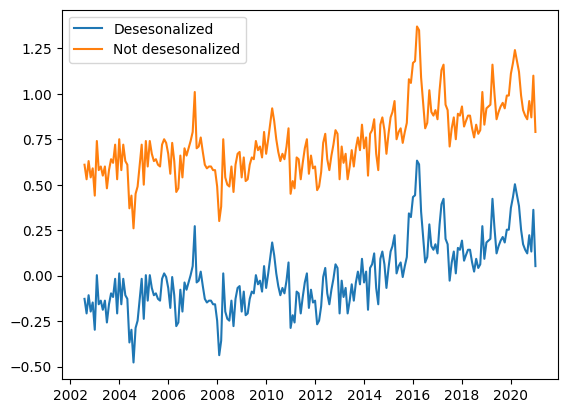

In [25]:
mean0220 = np.mean(gmst_anom_raghu)
corregido = gmst_anom_raghu - mean0220
corregido.shape
start_date = "2002-07"  # January 1850
end_date = "2021-01"    # December 2020

# Generate the monthly dates
dates = pd.date_range(start=start_date, end=end_date, freq="M").to_numpy()
plt.plot(dates,corregido, label="Desesonalized")
plt.plot(dates,gmst_anom_raghu, label="Not desesonalized")
plt.legend()

In [26]:
#x=np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).reshape(-1,1)
#y=np.array([0.113, 0.116, 0.130, 0.150, 0.150, 0.160, 0.180, 0.210, 0.220, 0.260, 0.280])

y = lwR_trop_mean.sel(press=1, opt=1).data
x = corregido.reshape(-1,1)
regression=LinearRegression(fit_intercept=False).fit(x,y)
regression.coef_[0], regression.intercept_
#plt.scatter(corregido, lwR_trop_mean.sel(press=1, opt=1))
#plt.plot(corregido, lw_regress.slope*corregido + lw_regress.intercept, "-r")

#slope_no_intercept = np.sum((bint- bint.mean("time")) * (gmst_anom_raghu- np.mean(gmst_anom_raghu))) / np.sum((gmst_anom_raghu - np.mean(gmst_anom_raghu))**2)
#print(slope_no_intercept)
#lw_regress.slope, lw_regress.stderr, lw_regress.intercept, lw_regress.intercept_stderr

#regression=LinearRegression(fit_intercept=True).fit(x,y)

(-0.034502313, 0.0)

In [27]:
regression.score(x,y)

0.07399845123291016

In [28]:
bint = lwR_trop_mean.sel(press=1, opt=1)
bintmean = bint.mean()
new_intercept = bintmean - lw_regress.slope * mean0220
new_intercept

NameError: name 'lw_regress' is not defined

In [ ]:

lw_regress = stats.linregress(corregido, bint)
plt.scatter(corregido, lwR_trop_mean.sel(press=1, opt=1))
plt.plot(corregido, lw_regress.slope*corregido + lw_regress.intercept, "-r")

slope_no_intercept = np.sum((bint- bint.mean("time")) * (gmst_anom_raghu- np.mean(gmst_anom_raghu))) / np.sum((gmst_anom_raghu - np.mean(gmst_anom_raghu))**2)
print(slope_no_intercept)
lw_regress.slope, lw_regress.stderr, lw_regress.intercept, lw_regress.intercept_stderr

NameError: name 'bint' is not defined

### Total Feedbacks

In [ ]:
#6
lw_feed_slope =  np.zeros([7,6])
lw_feed_st =  np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bint = lwR_trop_mean.sel(press=p, opt=od)
        #lw_regress = stats.linregress(corregido, bint)
        lw_regress = sm.OLS(bint.data, corregido.astype("float32")).fit()
        lw_feed_slope[p, od] = lw_regress.params[0] #.slope
        lw_feed_st[p, od] = lw_regress.bse[0] #.stderr

lwfeed_trops = xa.DataArray(lw_feed_slope,
                    coords={"press": lwR_trop_mean.press, "opt":lwR_trop_mean.opt, 
                           },
                   )

lwfeed_trops_st = xa.DataArray(lw_feed_st,
                    coords={"press": lwR_trop_mean.press, "opt":lwR_trop_mean.opt, 
                           },
                   )

In [ ]:
ts, lwfeed_trops_st.sum(["opt", "press"]).data

(1.970756270488079, array(0.4490752))

In [ ]:
# Calculate degrees of freedom
n = 222  # Number of data points
dof = n - 1 # Only the slope is estimated

# Calculate critical t-value for 95% confidence
t_crit = t.ppf(0.975, dof)

std_errors_slope = lwfeed_trops_st.sel(press=[4,5,6]).sum(["press", "opt"]).data
total_variance_slope = np.sum(std_errors_slope ** 2)
SE_sum_slope = np.sqrt(total_variance_slope)
slope = -0.34735700697638094 
# Compute the confidence intervals
slope_ci = (slope- t_crit * SE_sum_slope, slope + t_crit * SE_sum_slope)

print(f"Slope: {slope:.4f}")
print(f"Slope: {total_variance_slope:.4f}")
print(f"95% Confidence Interval for Slope: {slope_ci}")
t_crit# * np.sum(std_errors_slope)


Slope: -0.3474
Slope: 0.1073
95% Confidence Interval for Slope: (-0.9928345012496785, 0.29812048729691665)


1.9707562704880786

Tropical LW feedback =  -0.5107747220317833
High cloud Tropical LW feedback =  -0.34735700697638094 +- 0.32752781454473734
Low-mid cloud Tropical LW feedback =  -0.16341771505540237


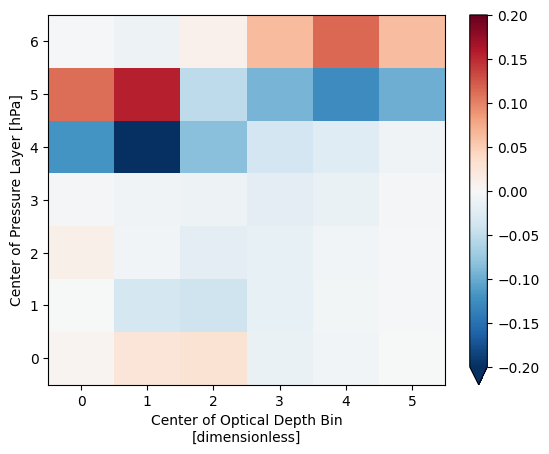

In [ ]:
print("Tropical LW feedback = ", lwfeed_trops.sum(["opt", "press"]).data)
print("High cloud Tropical LW feedback = ", lwfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data,"+-" ,lwfeed_trops_st.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical LW feedback = ", lwfeed_trops.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
lwfeed_trops.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")
#-0.5034, -0.3448, -0.1586

In [ ]:
lwfclass = methods.Feedbacks(area_trop, lwK_trop, gmst_anom_raghu)
lwfclass


$\lambda$

In [ ]:
lwctp = lwfclass.ctp()

lwctp[0].sel(press=[4,5,6]).sum(["press", "opt"])

Total feedback = -0.5107750829360821 +- 0.8870271471137862


<xarray.DataArray ()>
array(-0.34735726)

In [ ]:
lwfclass.total(lwctp.sel(press=[4,5,6]))

Total feedback = -0.5107750829360821 +- 0.8870271471137862


(array(-0.51077508), 0.8870271471137862)

In [ ]:
hclw = methods.Feedbacks(area_trop.sel(press=[4,5,6]), lwK_trop.sel(press=[4,5,6]), corregido)
hcsw = methods.Feedbacks(area_trop.sel(press=[4,5,6]), swK_trop.sel(press=[4,5,6]), corregido)
hcnet = methods.Feedbacks(area_trop.sel(press=[4,5,6]), K_trop.sel(press=[4,5,6]), corregido)

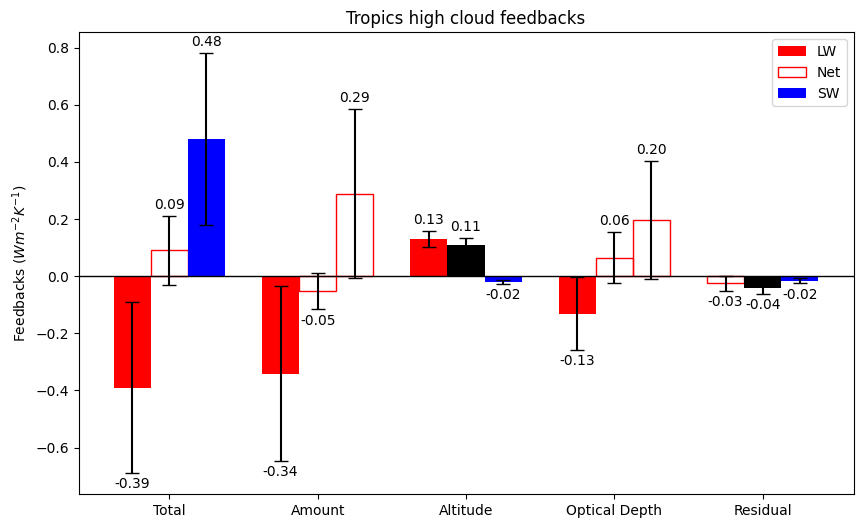

In [ ]:
methods.plot(hclw, hcsw, hcnet, "Tropics", (-0.39,0.3), (0.48,0.3), (0.09,0.12) )

In [ ]:
methods.summary(hclw, hcsw, hcnet,  (-0.39,0.3), (0.48,0.3), (0.09,0.12))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,-0.3900,0.3000,0.4800,0.3000,0.0900,0.1200
Amount,-0.3411,0.3056,0.2892,0.2967,-0.0519,0.0642
Altitude,0.1296,0.0290,-0.0204,0.0063,0.1093,0.0238
Optical Depth,-0.1309,0.1282,0.1957,0.2058,0.0648,0.0900
Residual,-0.0252,0.0268,-0.0160,0.0091,-0.0413,0.0196


In [ ]:
#6
sw_feed =  np.zeros([7,6])
sw_feed_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = swR_trop_mean.sel(press=p, opt=od)
        sw_regress = stats.linregress(gmst_anom_raghu, bints)
        sw_feed[p, od] = sw_regress.slope
        sw_feed_st[p, od] = sw_regress.stderr

swfeed_trops = xa.DataArray(sw_feed, 
                    coords={"press": swR_trop_mean.press, "opt":swR_trop_mean.opt, 
                           },
                   )

swfeed_trops_st = xa.DataArray(sw_feed_st, 
                    coords={"press": swR_trop_mean.press, "opt":swR_trop_mean.opt, 
                           },
                   )

0.7855354954901275 0.7061748018147223
High cloud Tropical SW feedback =  0.43392271698881896 +- 0.3194521059663735
Low-mid cloud Tropical SW feedback =  0.35161277850130856


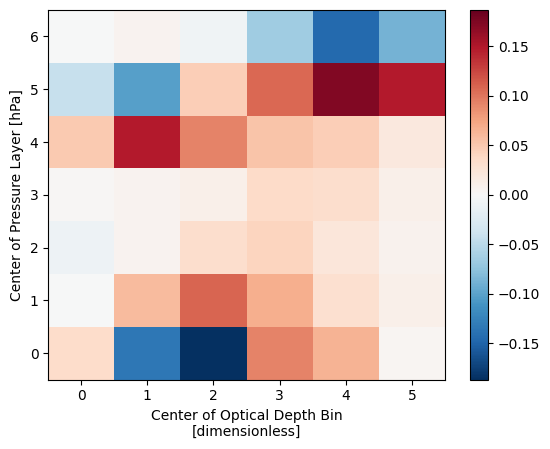

In [ ]:
print(swfeed_trops.sum(["press", "opt"]).data, swfeed_trops_st.sum(["press", "opt"]).data) 
print("High cloud Tropical SW feedback = ", swfeed_trops.sel(press=[4,5,6]).sum(["press", "opt"]).data,"+-" ,swfeed_trops_st.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical SW feedback = ", swfeed_trops.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
(swfeed_trops).plot()
# 0.7710, 0.4199, 0.3511

In [ ]:
print("Tropical SW feedback sd = ", np.sum( sw_feed_st))
print("High cloud Tropical SW feedback = ", np.sum( sw_feed_st[4:,:]))
print("Low-mid cloud Tropical SW feedback = ", np.sum( sw_feed_st[:4,:]))

Tropical SW feedback sd =  0.7061748018147223
High cloud Tropical SW feedback =  0.3194521059663735
Low-mid cloud Tropical SW feedback =  0.3867226958483488


In [ ]:
#6
netR_trop = K_trop.mean("time")*cc_trop_anom

netR_trop_mean = netR_trop.mean(["lat"]) #weighted(weights=weights).

net_feed =  np.zeros([7,6])
net_feed_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = netR_trop_mean.sel(press=p, opt=od)
        net_regress = stats.linregress(gmst_anom_raghu, bints)
        net_feed[p, od] = net_regress.slope
        net_feed_st[p, od] = net_regress.stderr

netfeed_tropsr = xa.DataArray(net_feed, 
                    coords={"press": netR_trop_mean.press, "opt":netR_trop_mean.opt, 
                           },
                   )

netfeed_trop_st = xa.DataArray(net_feed_st, 
                    coords={"press": netR_trop_mean.press, "opt":netR_trop_mean.opt, 
                           },
                   )

0.27476075782517784 0.3926252560485955
High cloud Tropical net feedback =  0.08656580758728014
Low-mid cloud Tropical net feedback =  0.18819495023789767
-0.13748360466615886 0.31061521984071916
0.224049412253439


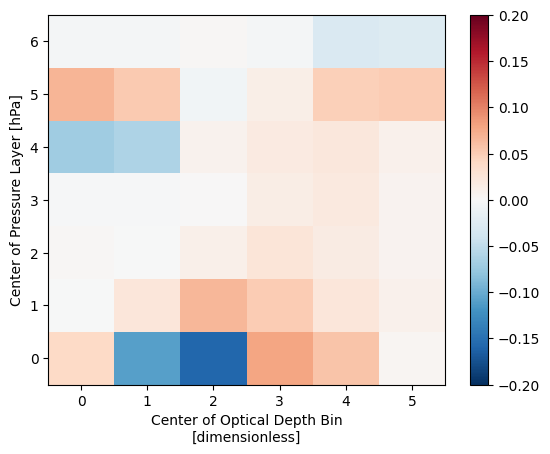

In [ ]:
#netfeed_trops = swfeed_trops + lwfeed_trops
print(netfeed_tropsr.sum(["press", "opt"]).data, netfeed_trop_st.sum(["press", "opt"]).data)
print("High cloud Tropical net feedback = ", netfeed_tropsr.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud Tropical net feedback = ", netfeed_tropsr.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
netfeed_tropsr.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")

# Calculate the variance of the sum
# Como estoy calculando el total como la suma de los bins, la desviacion std es tambien la suma de las desvst
variance_of_sum = netfeed_trop_st.sel(press=[4,5,6]).sum(["press", "opt"])**2

# Standard deviation of the sum
sd_of_sum = np.sqrt(variance_of_sum.data)

# Confidence interval
ci = ts * sd_of_sum

print(netfeed_tropsr.sel(press=[4,5,6]).sum(["press", "opt"]).data - ci , netfeed_tropsr.sel(press=[4,5,6]).sum(["press", "opt"]).data+ci)
print(ci)

In [ ]:
import statsmodels.api as sm
xs = gmst_anom_raghu
xs = sm.add_constant( xs )
ys = bints.data
model = sm.OLS( ys, xs )
results = model.fit()
results.conf_int( alpha=0.05 )

array([[ 0.01143084,  0.02918191],
       [-0.03918098, -0.01587604]])

Text(0.5, 1.0, 'c) Tropical-mean net feedback')

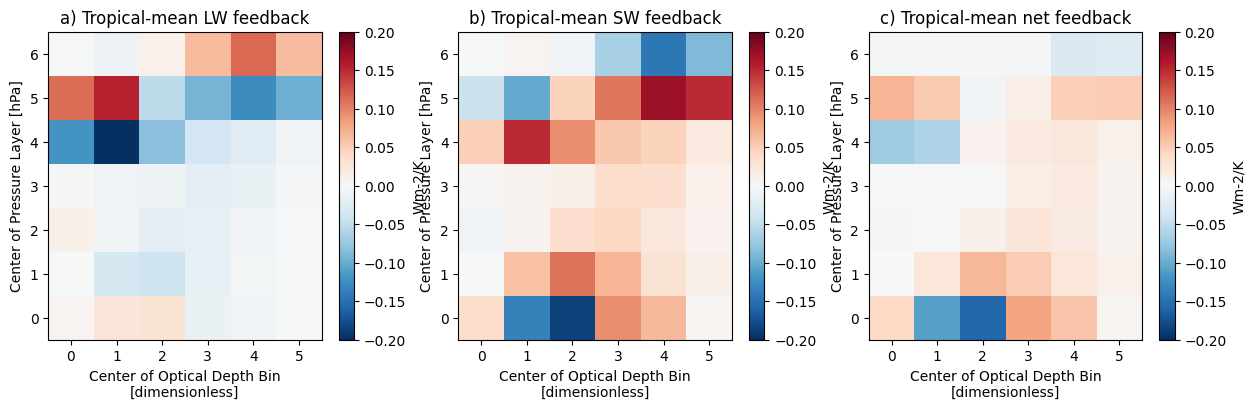

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwfeed_trops.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) Tropical-mean LW feedback")
swfeed_trops.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) Tropical-mean SW feedback")
netfeed_tropsr.plot(cmap="RdBu_r", vmin=-0.2, vmax=0.2, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) Tropical-mean net feedback")
#plt.savefig("feedbacks.png")

## Decomposition

In [ ]:
# Calculate the critical t-value
t_value = t.ppf(0.975, df=222-1) # Number of data points per regression - Number of predictors (slope only)

#RAGHURAMAN'S net feedback res 
0.09 - 0.12 - 0.06 +0.05

-0.039999999999999994

In [ ]:
cTot_anom = (cc_trop_anom.sel(press=[4,5,6]).sum(["press", "opt"])) # .mean("lat")
cTot = (area_trop.sel(press=[4,5,6]).sum(["press", "opt"])) # .mean("lat")

#I have tried meaning mlat before but it's worse

In [ ]:
def hc_feedbacks(area,K,which, sst_anom=gmst_anom_raghu):
    
    i = ["press", "opt"]
    if which not in i:
        raise NameError(f"Decompsitions only in {i} dims")
    
    opp  = i[i.index(which) - 1]

    cTot = (area.sel(press=[4,5,6]).sum(["press", "opt"])) 
    cc_anom = area.sel(press=[4,5,6]).groupby('time.month')- area.sel(press=[4,5,6]).groupby('time.month').mean('time')
    cTot_anom = (cc_anom.sel(press=[4,5,6]).sum(["press", "opt"]))
    
    cc_ast = cc_anom - (area.sel(press=[4,5,6])/cTot)*cTot_anom

    ci_Tot = (area.sel(press=[4,5,6])/cTot).sum(which)
    Ktau = K.sel(press=[4,5,6])*ci_Tot.sum(opp)

    K_prima = (Ktau * ci_Tot).sum(opp)

    casi_R = K_prima*cc_ast.sum(opp)

    R_altitude = casi_R.sum(which)

    feedback_i = stats.linregress(sst_anom, R_altitude.mean("lat"))
    
    return feedback_i.slope, t_value*feedback_i.stderr

### Amount

In [ ]:
t_value = t.ppf(0.975, df=162-1)
t_value

1.974808091744976

In [ ]:
def feedback_amount(area,K, sst_anom):
    cTot = area.sum(["press", "opt"])
    cc_anom = area.groupby("time.month") - area.groupby("time.month").mean("time")
    cTot_anom = cc_anom.sum(["press", "opt"])
    K_0 = ((area/cTot)*K).sum(["opt", "press"])
    Ramt_anom = K_0*cTot_anom
    regress = stats.linregress(sst_anom, Ramt_anom.mean("lat"))
    return regress.slope, t_value*regress.stderr

In [ ]:
#option 3 -> The one 
K_0_hc = (((area_trop.sel(press=[4,5,6])/cTot))*K_trop.sel(press=[4,5,6])).sum(["opt", "press"])
Ramt_anom = K_0_hc*cTot_anom
Ramt_anom.dims
stats.linregress(gmst_anom_raghu, Ramt_anom.mean("lat")).slope, ts*stats.linregress(gmst_anom_raghu, Ramt_anom.mean("lat")).stderr

NameError: name 'cTot' is not defined

steps:

1- select high clouds from kernel and area

2- compute the equation. C and Ctot must be already summed

3- sum what needs to be summed, either od or press, once the equation is computed

4- Keep lat until just before regressing

### Altitude

In [ ]:
cc_anom = area_trop.sel(press=[4,5,6]).groupby('time.month')- area_trop.sel(press=[4,5,6]).groupby('time.month').mean('time')

In [ ]:
cc_ast = cc_anom - (area_trop.sel(press=[4,5,6])/cTot)*cTot_anom

In [ ]:
cpTot = (area_trop.sel(press=[4,5,6])/cTot).sum("press")
Ktau = K_trop.sel(press=[4,5,6])*cpTot.sum("opt")
Ktau.dims

K_prima = (Ktau * cpTot).sum("opt")
K_prima.dims

casi_R = K_prima*cc_ast.sum("opt")
casi_R.dims
R_altitude = casi_R.sum("press")

feed_altitude = stats.linregress(gmst_anom_raghu, R_altitude.mean("lat"))
feed_altitude.slope, ts*feed_altitude.stderr

(0.10925223262524657, 0.02378695405481745)

### Optical depth

In [ ]:
ctTot = (area_trop.sel(press=[4,5,6])/cTot).sum("opt")
Kp = K_trop.sel(press=[4,5,6])*ctTot.sum("press")
print(Kp.dims)

K_prima_t = (Kp * ctTot).sum("press")
print(K_prima_t.dims)
casi_R = K_prima_t*cc_ast.sum("press")
R_tau = casi_R.sum("opt")

feed_od = stats.linregress(gmst_anom_raghu, R_tau.mean("lat"))
feed_od.slope, ts*feed_od.stderr

('time', 'lat', 'opt', 'press')
('time', 'lat', 'opt')


(0.06477566182591352, 0.08998700206696622)

### Rest

In [ ]:
def res_feedbacks(area, K, sst_anom):

        cTot = area.sel(press=[4, 5, 6]).sum(["press", "opt"])
        cc_anom = area.sel(press=[4, 5, 6]).groupby("time.month") - area.sel(
            press=[4, 5, 6]
        ).groupby("time.month").mean("time")
        cTot_anom = cc_anom.sel(press=[4, 5, 6]).sum(["press", "opt"])

        cc_ast = cc_anom - (area.sel(press=[4, 5, 6]) / cTot) * cTot_anom

        ct_Tot = (area.sel(press=[4, 5, 6]) / cTot).sum("press")
        Kp = K.sel(press=[4, 5, 6]) * ct_Tot.sum("opt")
        K_prima_press = (Kp * ct_Tot).sum("opt")

        cp_Tot = (area.sel(press=[4, 5, 6]) / cTot).sum("opt")
        Ktau = K.sel(press=[4, 5, 6]) * cp_Tot.sum("press")
        K_prima_tau = (Ktau * cp_Tot).sum("press")

        K_R = K - K_prima_press - K_prima_tau

        R_res = (K_R * cc_ast).sum(["press", "opt"])

        feed_res = stats.linregress(sst_anom, R_res.mean("lat"))
        return feed_res


In [ ]:
res_feedbacks(area_trop, K_trop, gmst_anom_raghu)

LinregressResult(slope=-0.041261816055302755, intercept=0.02919702986178909, rvalue=-0.26996754480304347, pvalue=4.5885786744527916e-05, stderr=0.009921854100867359, intercept_stderr=0.007558727346950698)

In [ ]:
rest =  0.07453115191492792 - (-0.05191400099916782) - feed_altitude.slope - feed_od.slope
rest_ci = 0.39263 - 0.0642 - 0.02378 - 0.0899
#total 
rest, rest_ci

(-0.047582741537064335, 0.21475)

In [ ]:
#another test
net_feed =  np.zeros([6])
for od in [0,1,2,3,4,5]:
    bints = netR_trop_mean.sel( press=[4,5,6]).sum("press").sel( opt=od)
    net_regress = stats.linregress(gmst_anom_raghu, bints)
    net_feed[od] = net_regress.slope

net_feed

net_feed.sum() #result=0.074

0.08656580621537543

### LW and SW

In [ ]:
#LW
a = feedback_amount(area_trop.sel(press=[4,5,6]), lwK_trop.sel(press=[4,5,6]), gmst_anom_raghu)

b = hc_feedbacks(area_trop, lwK_trop, "press")

c = hc_feedbacks(area_trop, lwK_trop, "opt")

res_reg = res_feedbacks(area_trop, lwK_trop, gmst_anom_raghu)
res_ITCZ = res_reg.slope, res_reg.stderr 

print(f"hc amount = {a[0]} +- {a[1]}")
print(f"hc altitude = {b[0]} +- {b[1]}")
print(f"hc od = {c[0]} +- {c[1]}")
print(f"hc res = {res_reg.slope} +-{ts*res_reg.stderr} ")

hc amount = -0.3411118172075701 +- 0.30559202952775716
hc altitude = 0.12959064140593823 +- 0.02896318662575861
hc od = -0.13094544900281374 +- 0.1281903949560082
hc res = -0.025194982235312944 +-0.02681877865779265 


In [ ]:
a = feedback_amount(area_trop.sel(press=[4,5,6]), swK_trop.sel(press=[4,5,6]), gmst_anom_raghu)

b = hc_feedbacks(area_trop, swK_trop, "press")

c = hc_feedbacks(area_trop, swK_trop, "opt")

res_reg = res_feedbacks(area_trop, swK_trop, gmst_anom_raghu)

print(f"hc sw amount = {a[0]} +- {a[1]}")
print(f"hc sw altitude = {b[0]} +- {b[1]}")
print(f"hc sw od = {c[0]} +- {c[1]}")
print(f"hc res = {res_reg.slope} +-{ts*res_reg.stderr} ")

hc sw amount = 0.28919778505295773 +- 0.29668877463786997
hc sw altitude = -0.02036094466627749 +- 0.006316838212268411
hc sw od = 0.19572398376930442 +- 0.20583422925925796
hc res = -0.01604760824261464 +-0.009130574127523525 


# ITCZ

In [ ]:
RclrLW_itcz = alllw.sel(lat=itcz,lon=ocean_only, time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_itcz = alllw.sel(lat=itcz,lon=ocean_only, time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_itcz = (RclrLW_itcz - RovcLW_itcz)/100

In [ ]:
RclrSW_itcz = allsw.sel(lat=itcz,lon=ocean_only,time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_itcz = allsw.sel(lat=itcz,lon=ocean_only,time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_itcz = (RclrSW_itcz - RovcSW_itcz)/100

In [ ]:
K_itcz = swK_itcz + lwK_itcz

Text(0.5, 1.0, 'c) ITCZ-mean net kernel')

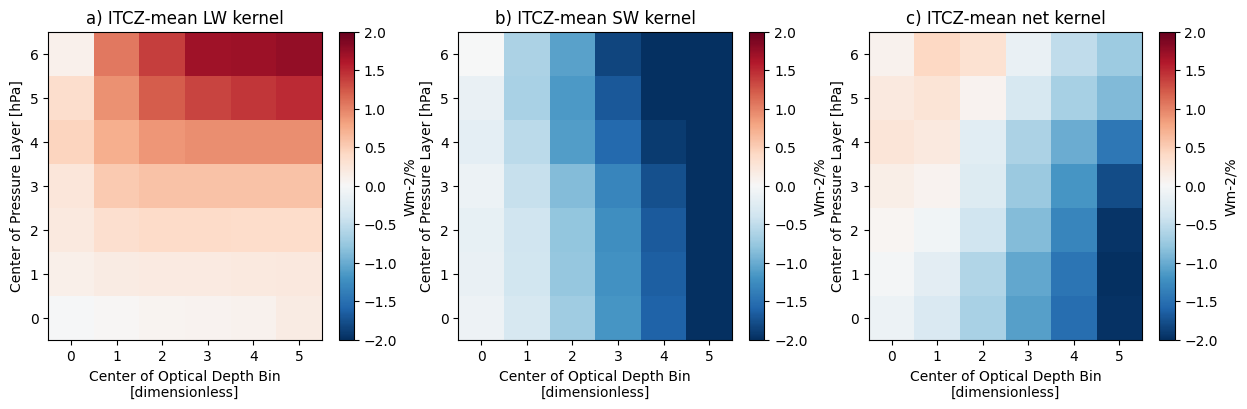

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwK_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) ITCZ-mean LW kernel")
swK_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) ITCZ-mean SW kernel")
K_itcz.mean(["lat","time"]).transpose().plot(cmap="RdBu_r", vmin=-2.0, vmax=2.0, cbar_kwargs={'label': "Wm-2/%", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) ITCZ-mean net kernel")
#plt.savefig("kernels.png")

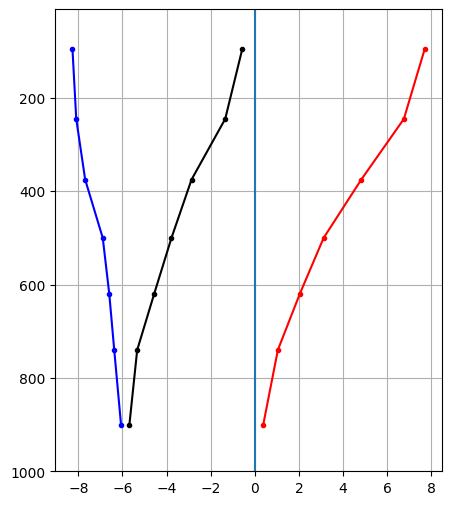

In [ ]:
plt.figure(figsize=(5,6))
plt.plot(lwK_itcz.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-r")
plt.plot(swK_itcz.mean(["lat","time"]).sum("opt"),  midpoints[1:], ".-b")
plt.plot(K_itcz.mean(["lat","time"]).sum("opt"), midpoints[1:], ".-k")
plt.gca().invert_yaxis()
plt.ylim(1000,10)
plt.vlines(0, ymin=1000, ymax=10)
plt.grid()

IN conclusion, kernels dont change much with area or time

In [ ]:
#2
area_itcz = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=ocean_only,time=ragutime).mean("lon")
cc_itcz_anom = area_itcz.groupby('time.month')- area_itcz.groupby('time.month').mean('time')

In [ ]:
#3
lwR_itcz = lwK_itcz*cc_itcz_anom
swR_itcz = swK_itcz*cc_itcz_anom

In [ ]:
lw_itcz = np.cos(np.deg2rad(lwR_itcz.lat))

lwR_itcz_mean = lwR_itcz.weighted(weights=lw_itcz).mean("lat") 
swR_itcz_mean = swR_itcz.weighted(weights=lw_itcz).mean("lat")

In [ ]:
lw_feed_itcz =  np.zeros([7,6])
lw_feed_itcz_st =  np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints_itcz = lwR_itcz_mean.sel(press=p, opt=od)
        lw_regress  = stats.linregress(gmst_anom_raghu, bints_itcz)
        lw_feed_itcz[p, od] = lw_regress.slope
        lw_feed_itcz_st[p, od] = lw_regress.stderr

lwfeed_itcz = xa.DataArray(lw_feed_itcz,  
                    coords={"press": lwR_itcz_mean.press, "opt":lwR_itcz_mean.opt, 
                           },
                   )

lwfeed_itcz_st = xa.DataArray(lw_feed_itcz_st,  
                    coords={"press": lwR_itcz_mean.press, "opt":lwR_itcz_mean.opt, 
                           },
                   )

1.3383966100506575 +- 1.520560213603631
High cloud ITCZ LW feedback =  1.4496639295275775 +- 1.2636932395691656
Low-mid cloud ITCZ LW feedback =  1.4496639295275775


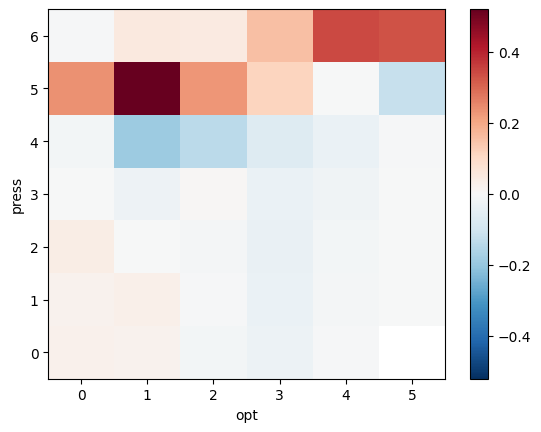

In [ ]:
print(lwfeed_itcz.sum(["press", "opt"]).data,"+-" ,lwfeed_itcz_st.sum(["press", "opt"]).data)
print("High cloud ITCZ LW feedback = ", lwfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data,"+-" ,lwfeed_itcz_st.sel(press=[4,5,6]).sum(["press", "opt"]).data )
print("Low-mid cloud ITCZ LW feedback = ", lwfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data)
(lwfeed_itcz).plot() #vmin=-0.2, vmax=0.2, cmap="RdBu_r"

In [ ]:
sw_feed_itcz =  np.zeros([7,6])
sw_feed_itcz_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = swR_itcz_mean.sel(press=p, opt=od)
        sw_feed_itcz[p, od] = stats.linregress(gmst_anom_raghu, bints).slope
        sw_feed_itcz_st[p, od] = lw_regress.stderr


swfeed_itcz = xa.DataArray(sw_feed_itcz, 
                    coords={"press": swR_itcz_mean.press, "opt":swR_itcz_mean.opt, 
                           },
                   )
swfeed_itcz_st = xa.DataArray(sw_feed_itcz_st,  
                    coords={"press": swR_itcz_mean.press, "opt":swR_itcz_mean.opt, 
                           },
                   )

0.18910287214787314 +- 4.044237509351885
High cloud ITCZ SW feedback =  -1.4874384592212315 +- 1.7332446468650933
Low-mid cloud ITCZ SW feedback =  1.6765413313691049


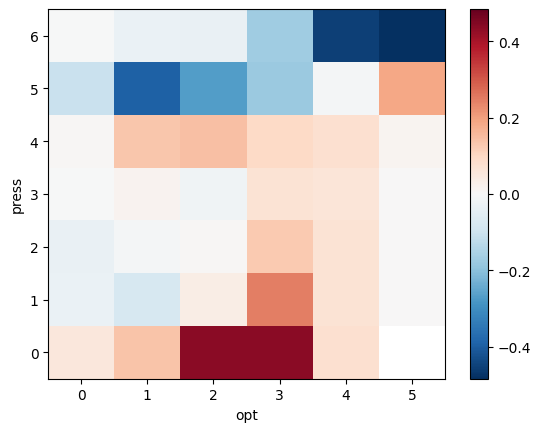

In [ ]:
print(swfeed_itcz.sum(["press", "opt"]).data,"+-" ,swfeed_itcz_st.sum(["press", "opt"]).data)
print("High cloud ITCZ SW feedback = ", swfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data,"+-" ,swfeed_itcz_st.sel(press=[4,5,6]).sum(["press", "opt"]).data )

print("Low-mid cloud ITCZ SW feedback = ", swfeed_itcz.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
(swfeed_itcz).plot() #vmin=-0.2, vmax=0.2, cmap="RdBu_r"

In [ ]:
#6
netR_itcz = K_itcz.mean("time")*cc_trop_anom
netR_itcz_mean = netR_itcz.mean(["lat"]) #weighted(weights=weights).

net_feed_itcz =  np.zeros([7,6])
net_feed_st = np.zeros([7,6])

for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = netR_itcz_mean.sel(press=p, opt=od)
        net_regress = stats.linregress(gmst_anom_raghu, bints)
        net_feed_itcz[p, od] = net_regress.slope
        net_feed_st[p, od] = net_regress.stderr

netfeed_itczr = xa.DataArray(net_feed_itcz, 
                    coords={"press": netR_itcz_mean.press, "opt":netR_itcz_mean.opt, 
                           },
                   )

netfeed_itcz_st = xa.DataArray(net_feed_st, 
                    coords={"press": netR_itcz_mean.press, "opt":netR_itcz_mean.opt, 
                           },
                   )

In [ ]:
#netfeed_itcz = swfeed_itcz + lwfeed_itcz
print(netfeed_itczr.sum(["press", "opt"]).data, "+-", netfeed_itcz_st.sum(["press", "opt"]).data)
print("High cloud itcz net feedback = ", netfeed_itczr.sel(press=[4,5,6]).sum(["press", "opt"]).data, "+-", netfeed_itcz_st.sel(press=[4,5,6]).sum(["press", "opt"]).data)
print("Low-mid cloud itcz net feedback = ", netfeed_itczr.sel(press=[0,1,2,3]).sum(["press", "opt"]).data)
netfeed_itczr.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r") 


# Calculate the variance of the sum
variance_of_sum = netfeed_itcz_st.sel(press=[4,5,6]).sum(["press", "opt"])**2

# Standard deviation of the sum
sd_of_sum = np.sqrt(variance_of_sum.data)

# Calculate the critical t-value
t_value = t.ppf(0.975, df=222-1) # Number of data points per regression - Number of predictors (slope only)

# Confidence interval
ci = t_value * sd_of_sum
print(netfeed_itczr.sel(press=[4,5,6]).sum(["press", "opt"]).data - ci , netfeed_itczr.sel(press=[4,5,6]).sum(["press", "opt"]).data+ci)

NameError: name 'netfeed_itczr' is not defined

Text(0.5, 1.0, 'c) ITCZ-mean net feedback')

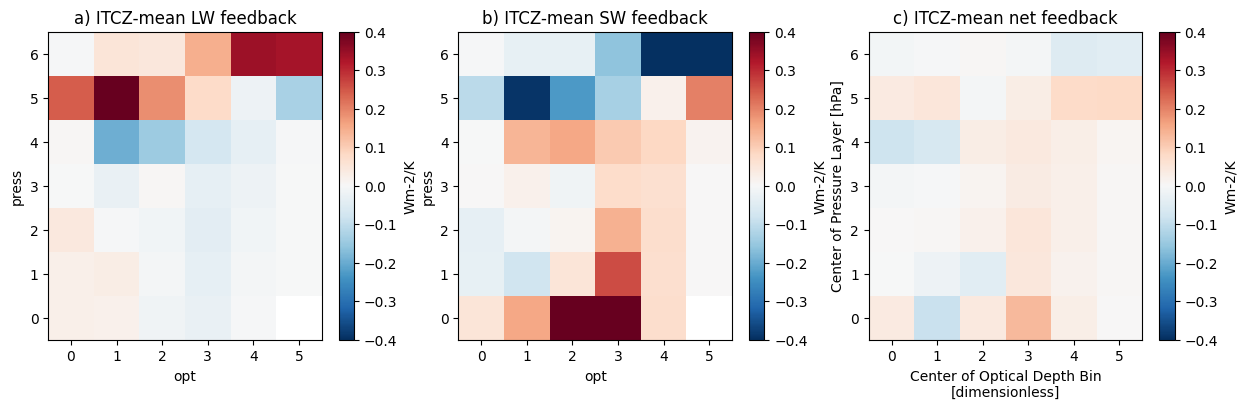

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4))

#fig.suptitle('Horizontally stacked subplots')
lwfeed_itcz.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax1)
ax1.set_title("a) ITCZ-mean LW feedback")
swfeed_itcz.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax2)
ax2.set_title("b) ITCZ-mean SW feedback")
netfeed_itczr.plot(cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label': "Wm-2/K", 'extend': 'neither'}, ax=ax3)
ax3.set_title("c) ITCZ-mean net feedback")
#plt.savefig("feedbacks_itcz.png")

## Decomposition

In [ ]:
# Calculate the critical t-value
t_value = t.ppf(0.975, df=222-1) # Number of data points per regression - Number of predictors (slope only)

In [ ]:
feed_itcz = total_feedback(area_itcz, K_itcz, gmst_anom_raghu)
print(feed_itcz[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_itcz[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_itcz = total_feedback(area_itcz, swK_itcz, gmst_anom_raghu)
print(feed_itcz[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_itcz[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_itcz = total_feedback(area_itcz, lwK_itcz, gmst_anom_raghu)
print(feed_itcz[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_itcz[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

0.08093944200754744 0.41895845223104233
-1.3693992249553082 1.3543482460825995
1.4503386614099452 1.2622728783044541


In [ ]:
hclw_itcz = methods.Feedbacks(area_itcz.sel(press=[4,5,6]), lwK_itcz.sel(press=[4,5,6]), corregido)
hcsw_itcz = methods.Feedbacks(area_itcz.sel(press=[4,5,6]), swK_itcz.sel(press=[4,5,6]), corregido)
hcnet_itcz = methods.Feedbacks(area_itcz.sel(press=[4,5,6]), K_itcz.sel(press=[4,5,6]), corregido)

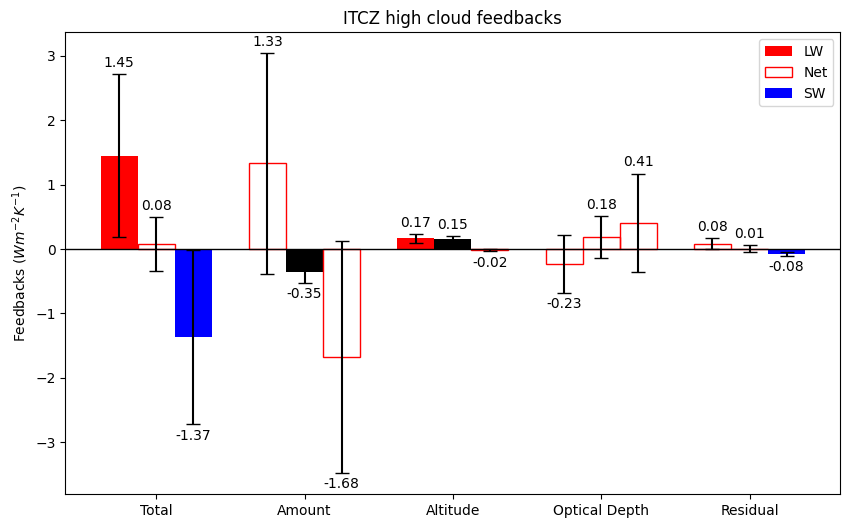

In [ ]:
methods.plot(hclw_itcz, hcsw_itcz, hcnet_itcz, totallw= (1.4503386614099452, 1.2622728783044541), totalsw=(-1.3693992249553082, 1.3543482460825995), totalnet=(0.08093944200754744, 0.41895845223104233))

In [ ]:
methods.summary(hclw_itcz, hcsw_itcz, hcnet_itcz, totallw= (1.4503386614099452, 1.2622728783044541), totalsw=(-1.3693992249553082, 1.3543482460825995), totalnet=(0.08093944200754744, 0.41895845223104233))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,1.4503,1.2623,-1.3694,1.3543,0.0809,0.4190
Amount,1.3282,1.7102,-1.6818,1.7996,-0.3536,0.1745
Altitude,0.1670,0.0689,-0.0187,0.0189,0.1484,0.0563
Optical Depth,-0.2293,0.4500,0.4106,0.7600,0.1813,0.3276
Residual,0.0821,0.0873,-0.0759,0.0339,0.0063,0.0583


In [ ]:
#LW
a_ITCZ = feedback_amount(area_itcz.sel(press=[4,5,6]), lwK_itcz.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_itcz, lwK_itcz, "press")

c_ITCZ = hc_feedbacks(area_itcz, lwK_itcz, "opt")

hc_tot = lwfeed_itcz.sel(press=[4,5,6]).sum(["press", "opt"]).data

res_reg =  res_feedbacks(area_itcz, lwK_itcz, gmst_anom_raghu)
res_ITCZ = res_reg.slope

print(f"{hc_tot},  {a_ITCZ[0]},{b_ITCZ[0]},{c_ITCZ[0]},{res_ITCZ}") 

# Confidence interval
ci_a = ts * a_ITCZ[1] #amount
ci_b = ts * b_ITCZ[1] #press
ci_c = ts * c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{ci_a}, {ci_b} , {ci_c}, {ci_res}")
#HC lw total 1.337571067966178


1.337571067966178,  1.313596581720907,0.16941544976425177,-0.3150654611394081,0.08490185233312392
1.7810441776364814, 0.07272617994699726 , 0.47590347821405804, 0.09317563749075278


In [ ]:
#SW
a_ITCZ = feedback_amount(area_itcz.sel(press=[4,5,6]), swK_itcz.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_itcz, swK_itcz, "press")

c_ITCZ = hc_feedbacks(area_itcz, swK_itcz, "opt")

res_reg = res_feedbacks(area_itcz, swK_itcz, gmst_anom_raghu)
res_ITCZ = res_reg.slope, res_reg.stderr 

print(a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

# Confidence interval
ci_a = a_ITCZ[1] #amount
ci_b = b_ITCZ[1] #press
ci_c = c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{ci_a}, {ci_b} , {ci_c}, {ci_res}")

(-1.6699248508960622, 1.8834006892377213) (-0.01957809206977185, 0.01970579052418596) (0.5481017888383682, 0.8074211989340057) (-0.07683537450483349, 0.018286003244041033)
1.8834006892377213, 0.01970579052418596 , 0.8074211989340057, 0.03603725555535922


In [ ]:
#Net
a_ITCZ = feedback_amount(area_itcz.sel(press=[4,5,6]), K_itcz.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_itcz, K_itcz, "press")

c_ITCZ = hc_feedbacks(area_itcz, K_itcz, "opt")

res_reg = res_feedbacks(area_itcz, K_itcz, gmst_anom_raghu)
res_ITCZ = res_reg.slope, res_reg.stderr 

print(a_ITCZ,b_ITCZ,c_ITCZ,res_ITCZ) 

# Confidence interval
ci_a = a_ITCZ[1] #amount
ci_b = b_ITCZ[1] #press
ci_c = c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{ci_a}, {ci_b} , {ci_c}, {ci_res}")


(-0.35632827511278137, 0.18696083169282698) (0.1498373499917237, 0.05910447224317696) (0.23303635390372227, 0.349482195233382) (0.008066499002157328, 0.03157762543895859)
0.18696083169282698, 0.05910447224317696 , 0.349482195233382, 0.06223180334095152


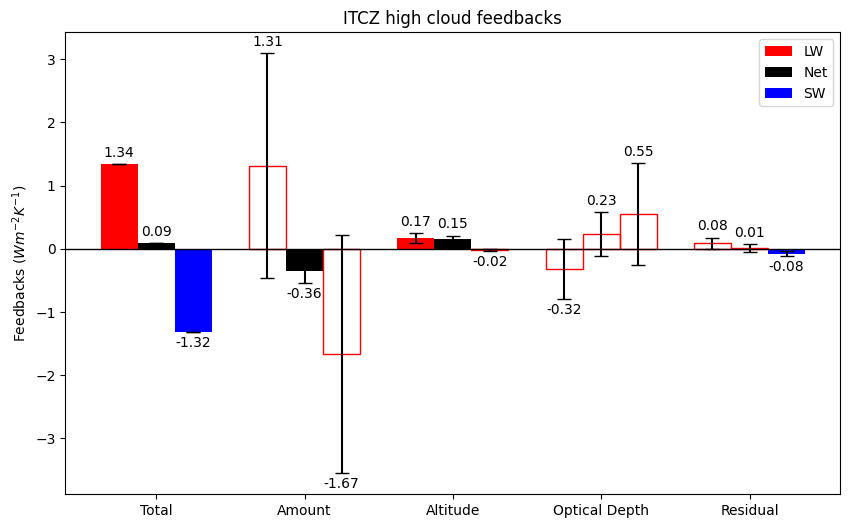

In [ ]:
decompos = ("Total", "Amount", "Altitude", "Optical Depth", "Residual")
feeds_itcz = {
    'LW': (1.337571067966178, 1.313596581720907, 0.16941544976425177, -0.3150654611394081, 0.08490185233312392),
    'Net': (0.08656580758728014, -0.35632827511278137, 0.1498373499917237, 0.23303635390372227, 0.008066499002157328),
    'SW': (-1.319930870039883, -1.6699248508960622 ,-0.01957809206977185, 0.5481017888383682, -0.07683537450483349),
}

ci_upper = {
    'LW': feeds_itcz["LW"] + np.array([0, 1.7810441776364814, 0.07272617994699726 , 0.47590347821405804, 0.09317563749075278]),
    'Net': feeds_itcz["Net"] + np.array([0, 0.18696083169282698, 0.05910447224317696 , 0.349482195233382, 0.06223180334095152]), 
    'SW': feeds_itcz["SW"] + np.array([0,1.8834006892377213, 0.01970579052418596 , 0.8074211989340057, 0.03603725555535922]),
}
ci_lower = {
    'LW': feeds_itcz["LW"] - np.array([0, 1.7810441776364814, 0.07272617994699726 , 0.47590347821405804, 0.09317563749075278]),
    'Net': feeds_itcz["Net"] - np.array([0, 0.18696083169282698, 0.05910447224317696 , 0.349482195233382, 0.06223180334095152]),
    'SW': feeds_itcz["SW"] -np.array([0, 1.8834006892377213, 0.01970579052418596 , 0.8074211989340057, 0.03603725555535922]),
}


colors = {
    'LW': 'red',
    'Net': 'black',
    'SW': 'blue'
}

x = np.arange(len(decompos))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,6))

for attribute, measurement in feeds_itcz.items():
    offset = width * multiplier

    # Calculate asymmetric error bars
    lower_errors = [m - ci for m, ci in zip(measurement, ci_lower[attribute])]
    upper_errors = [ci - m for m, ci in zip(measurement, ci_upper[attribute])]
    yerr_values = (lower_errors, upper_errors)

    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=yerr_values, capsize=5, color=colors[attribute]) 

    for i, rect in enumerate(rects):
        lower_bound = ci_lower[attribute][i]
        upper_bound = ci_upper[attribute][i]
    
        if lower_bound <= 0 <= upper_bound:  # Not significant # Only apply to LW bars
            rect.set_facecolor('none')  # Remove filling for the first bar
            rect.set_edgecolor('red')

    ax.bar_label(rects, labels=[f"{value:.2f}" for value in measurement], padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Feedbacks ($Wm^{-2}K^{-1}$)')
ax.set_title('ITCZ high cloud feedbacks')
ax.legend(loc='upper right')
ax.set_xticks(x + width)
ax.set_xticklabels(["Total", "Amount", "Altitude", "Optical Depth", "Residual"])
ax.axhline(0, color="black", linewidth=1)

plt.show()

Overall, feedbacks are larger, which makes sense because area is smaller. In conclusion, same pattern than in the Tropics for altitude and OD feedbacks. Amount ant total are the other way round for SW and LW, but net is the same. The total net is even more close to 0 in the ITCZ in comparison to the Pacific. 
I don't know why the residual is so high, and is positive for LW and Net in contrast to tropics.  

## EP

In [71]:
#sel press antes o despues de mean lon? puede ser causa del error
area_ep = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=ep,time=ragutime).mean("lon")

RclrLW_ep = alllw.sel(lat=itcz,lon=ep, time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_ep = alllw.sel(lat=itcz,lon=ep, time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_ep = (RclrLW_ep - RovcLW_ep)/100

RclrSW_ep = allsw.sel(lat=itcz,lon=ep, time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_ep = allsw.sel(lat=itcz,lon=ep, time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_ep = (RclrSW_ep - RovcSW_ep)/100

K_ep = lwK_ep + swK_ep

-0.76801275225733


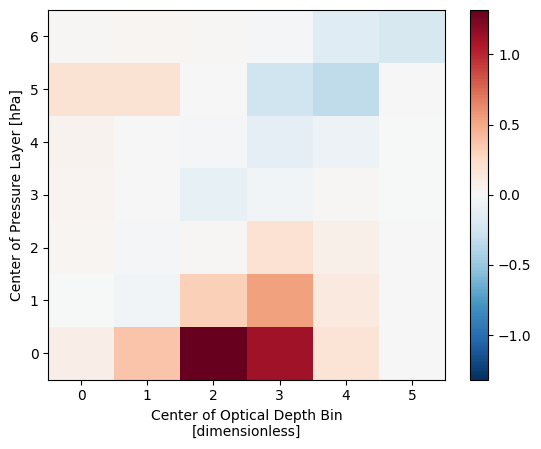

In [ ]:
feed_ep = total_feedback(area_ep, K_ep, gmst_anom_raghu)
print(feed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data)
feed_ep[0].plot()

-5.794989170353057


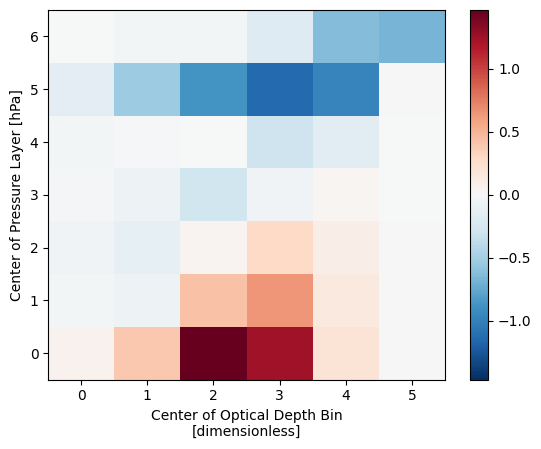

In [ ]:
swfeed_ep = total_feedback(area_ep, swK_ep)
print(swfeed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data)
swfeed_ep[0].plot()


5.026977098302147


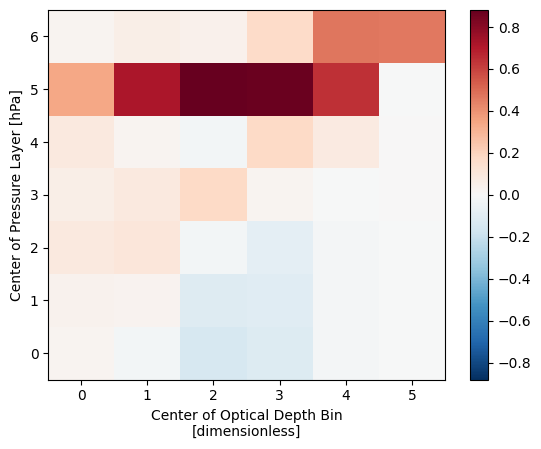

In [ ]:
#LW
lwfeed_ep = total_feedback(area_ep, lwK_ep)
print(lwfeed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data)
lwfeed_ep[0].plot()


In [ ]:
feed_ep = total_feedback(area_ep, K_ep, gmst_anom_raghu)
print(feed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_ep[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_ep = total_feedback(area_ep, swK_ep, gmst_anom_raghu)
print(feed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_ep[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_ep = total_feedback(area_ep, lwK_ep, gmst_anom_raghu)
print(feed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_ep[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

-0.76801275225733 0.5760341489283894
-5.794989170353057 1.9115519927932088
5.026977098302147 1.675674348286281


In [ ]:
hclw_ep = methods.Feedbacks(area_ep.sel(press=[4,5,6]), lwK_ep.sel(press=[4,5,6]), corregido)
hcsw_ep = methods.Feedbacks(area_ep.sel(press=[4,5,6]), swK_ep.sel(press=[4,5,6]), corregido)
hcnet_ep = methods.Feedbacks(area_ep.sel(press=[4,5,6]), K_ep.sel(press=[4,5,6]), corregido)

In [ ]:
methods.summary(hclw_ep, hcsw_ep, hcnet_ep, totallw= (5.026977098302147, 1.675674348286281), totalsw=(-5.794989170353057, 1.9115519927932088), totalnet=(-0.76801275225733, 0.5760341489283894))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,5.0270,1.6757,-5.7950,1.9116,-0.7680,0.5760
Amount,4.8103,2.5877,-5.8698,2.9370,-1.0595,0.4511
Altitude,0.1979,0.0793,0.0127,0.0277,0.2105,0.0641
Optical Depth,-0.2048,0.3399,0.2278,0.6408,0.0230,0.3256
Residual,0.0634,0.0783,-0.1020,0.0452,-0.0384,0.0490


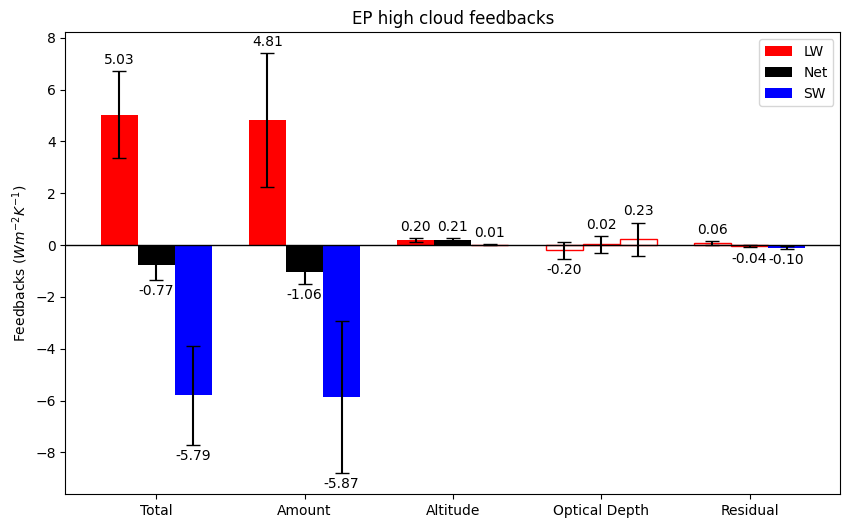

In [ ]:
methods.plot(hclw_ep, hcsw_ep, hcnet_ep, area="EP", totallw= (5.026977098302147, 1.675674348286281), totalsw=(-5.794989170353057, 1.9115519927932088), totalnet=(-0.76801275225733, 0.5760341489283894))

## WP

In [30]:
#sel press antes o despues de mean lon? puede ser causa del error
area_wp = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=wp,time=ragutime).mean("lon")

RclrLW_wp = alllw.sel(lat=itcz,lon=wp, time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_wp = alllw.sel(lat=itcz,lon=wp, time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_wp = (RclrLW_wp - RovcLW_wp)/100

RclrSW_wp = allsw.sel(lat=itcz,lon=wp, time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_wp = allsw.sel(lat=itcz,lon=wp, time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_wp = (RclrSW_wp - RovcSW_wp)/100

K_wp = lwK_wp + swK_wp

0.8912481889574548


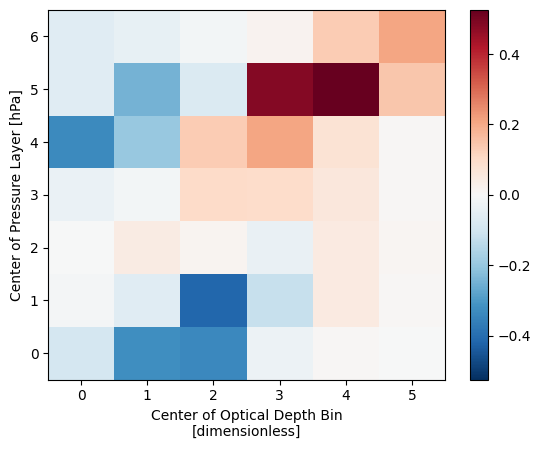

In [31]:
feed_wp = total_feedback(area_wp, K_wp, gmst_anom_raghu)
print(feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data)
feed_wp[0].plot()

In [32]:
#Net

a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), K_wp.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_wp, K_wp, "press")

c_ITCZ = hc_feedbacks(area_wp, K_wp, "opt")

res_reg =  res_feedbacks(area_wp, K_wp, gmst_anom_raghu)
res_ITCZ = res_reg.slope

hc_tot = feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data
print(f"{hc_tot[0]},  {a_ITCZ[0]},{b_ITCZ[0]},{c_ITCZ[0]},{res_ITCZ}") 

# Confidence interval
ci_a =  a_ITCZ[1] #amount
ci_b =  b_ITCZ[1] #press
ci_c =  c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{hc_tot[1]}, {ci_a}, {ci_b} , {ci_c}, {ci_res}")


NameError: name 'feedback_amount' is not defined

10.331767747765594


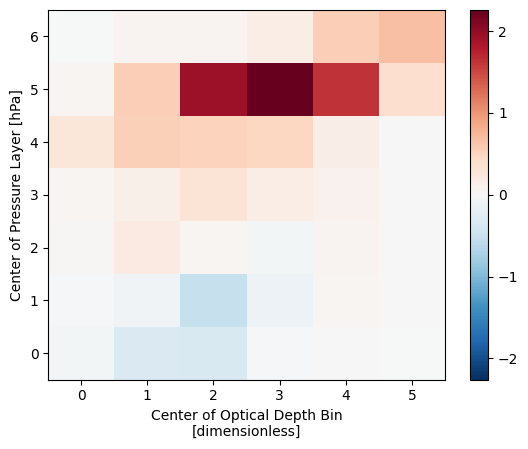

In [ ]:
swfeed_wp = total_feedback(area_wp, swK_wp)
print(swfeed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data)
swfeed_wp[0].plot()

In [ ]:
#SW

a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), swK_wp.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_wp, swK_wp, "press")

c_ITCZ = hc_feedbacks(area_wp, swK_wp, "opt")

res_reg =  res_feedbacks(area_wp, swK_wp, gmst_anom_raghu)
res_ITCZ = res_reg.slope

hc_tot = swfeed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, swfeed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data
print(f"{hc_tot[0]},  {a_ITCZ[0]},{b_ITCZ[0]},{c_ITCZ[0]},{res_ITCZ}") 

# Confidence interval
ci_a = a_ITCZ[1] #amount
ci_b = b_ITCZ[1] #press
ci_c = c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{hc_tot[1]}, {ci_a}, {ci_b} , {ci_c}, {ci_res}")

NameError: name 'res_feedbacks' is not defined

-9.44051633640516


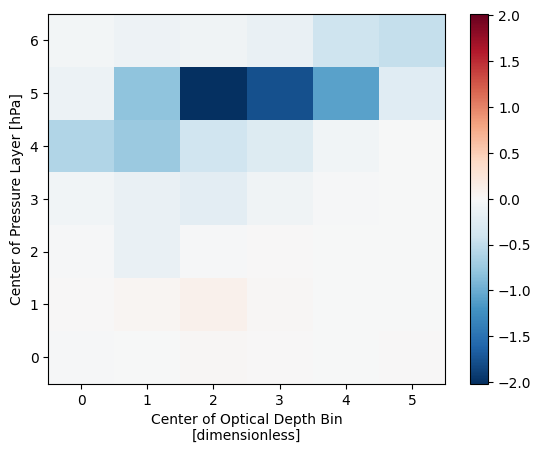

In [ ]:
lwfeed_wp = total_feedback(area_wp, lwK_wp)
print(lwfeed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data)
lwfeed_wp[0].plot()

In [33]:
#LW
a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), lwK_wp.sel(press=[4,5,6]), gmst_anom_raghu)

b_ITCZ = hc_feedbacks(area_wp, lwK_wp, "press")

c_ITCZ = hc_feedbacks(area_wp, lwK_wp, "opt")

res_reg =  res_feedbacks(area_wp, lwK_wp, gmst_anom_raghu)
res_ITCZ = res_reg.slope

hc_tot = lwfeed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, lwfeed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data
print(f"{hc_tot[0]},  {a_ITCZ[0]},{b_ITCZ[0]},{c_ITCZ[0]},{res_ITCZ}") 

# Confidence interval
ci_a = a_ITCZ[1] #amount
ci_b = b_ITCZ[1] #press
ci_c = c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{hc_tot[1]}, {ci_a}, {ci_b} , {ci_c}, {ci_res}")

NameError: name 'feedback_amount' is not defined

In [34]:
feed_wp = total_feedback(area_wp, K_wp, gmst_anom_raghu)
print(feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_wp = total_feedback(area_wp, swK_wp, gmst_anom_raghu)
print(feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_wp = total_feedback(area_wp, lwK_wp, gmst_anom_raghu)
print(feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

0.8912481889574548 0.8573478531012195
10.331767747765594 2.9600412835384033
-9.44051633640516 2.8064423613090046


In [35]:
hclw_wp = methods.Feedbacks(area_wp.sel(press=[4,5,6]), lwK_wp.sel(press=[4,5,6]), corregido)
hcsw_wp = methods.Feedbacks(area_wp.sel(press=[4,5,6]), swK_wp.sel(press=[4,5,6]), corregido)
hcnet_wp = methods.Feedbacks(area_wp.sel(press=[4,5,6]), K_wp.sel(press=[4,5,6]), corregido)

In [38]:
methods.summary(hclw_wp, hcsw_wp, hcnet_wp, totallw= (-9.44051633640516, 2.8064423613090046), totalsw=(10.331767747765594, 2.9600412835384033), totalnet=(0.8912481889574548, 0.8573478531012195))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,-9.4405,2.8064,10.3318,2.9600,0.8912,0.8573
Amount,-7.8678,3.5694,7.4641,3.5181,-0.4037,0.3987
Altitude,0.1480,0.1337,-0.0469,0.0430,0.1013,0.1001
Optical Depth,-1.4874,1.2162,2.6894,1.9765,1.2008,0.7948
Residual,-0.1777,0.2337,0.0583,0.1147,-0.1185,0.1299


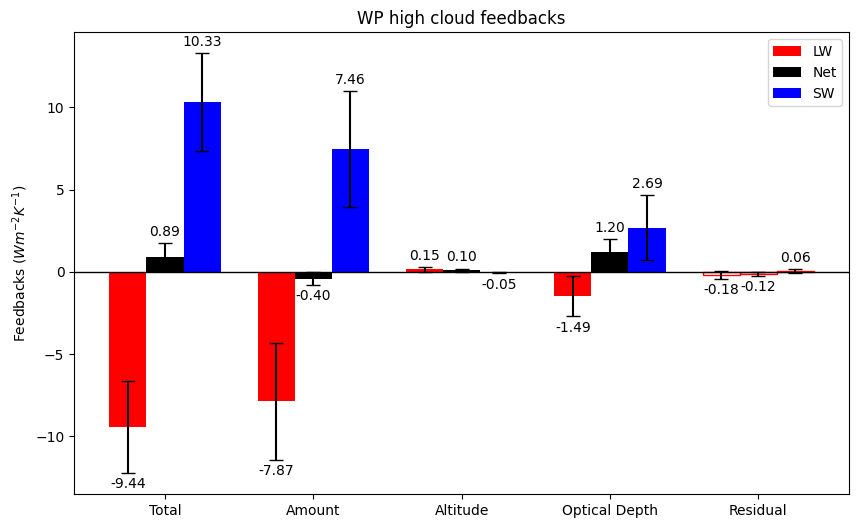

In [40]:
methods.plot(hclw_wp, hcsw_wp, hcnet_wp, area="WP", totallw= (-9.44051633640516, 2.8064423613090046), totalsw=(10.331767747765594, 2.9600412835384033), totalnet=(0.8912481889574548, 0.8573478531012195))

## CP

In [41]:
#sel press antes o despues de mean lon? puede ser causa del error
area_cp = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=cp,time=ragutime).mean("lon")

RclrLW_cp = alllw.sel(lat=itcz,lon=cp, time=ragutime).toa_lw_clr_mon.mean("lon")
RovcLW_cp = alllw.sel(lat=itcz,lon=cp, time=ragutime).toa_lw_cldtyp_mon.mean("lon")
lwK_cp = (RclrLW_cp - RovcLW_cp)/100

RclrSW_cp = allsw.sel(lat=itcz,lon=cp, time=ragutime).toa_sw_clr_mon.mean("lon")
RovcSW_cp = allsw.sel(lat=itcz,lon=cp, time=ragutime).toa_sw_cldtyp_mon.mean("lon")
swK_cp = (RclrSW_cp - RovcSW_cp)/100

K_cp = lwK_cp + swK_cp

In [42]:
feed_cp = total_feedback(area_cp, K_cp, gmst_anom_raghu)
print(feed_cp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_cp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_cp = total_feedback(area_cp, swK_cp, gmst_anom_raghu)
print(feed_cp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_cp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_cp = total_feedback(area_cp, lwK_cp, gmst_anom_raghu)
print(feed_cp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_cp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

0.35167901589319833 0.8420146034975553
-6.518872482955505 2.5567467982061474
6.8705518072760725 2.4877546369137686


In [44]:
hclw_cp = methods.Feedbacks(area_cp.sel(press=[4,5,6]), lwK_cp.sel(press=[4,5,6]), corregido)
hcsw_cp = methods.Feedbacks(area_cp.sel(press=[4,5,6]), swK_cp.sel(press=[4,5,6]), corregido)
hcnet_cp = methods.Feedbacks(area_cp.sel(press=[4,5,6]), K_cp.sel(press=[4,5,6]), corregido)

In [47]:
methods.summary(hclw_cp, hcsw_cp, hcnet_cp, totallw= (6.8705518072760725 ,2.4877546369137686), totalsw=(-6.518872482955505, 2.5567467982061474), totalnet=(0.35167901589319833, 0.8420146034975553))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,6.8706,2.4878,-6.5189,2.5567,0.3517,0.8420
Amount,5.1776,3.3590,-5.6462,3.2860,-0.4686,0.3874
Altitude,0.2395,0.1018,-0.0187,0.0665,0.2208,0.0722
Optical Depth,0.6959,0.8499,-0.7269,1.3437,-0.0310,0.5665
Residual,0.4321,0.1941,-0.2056,0.1063,0.2265,0.1181


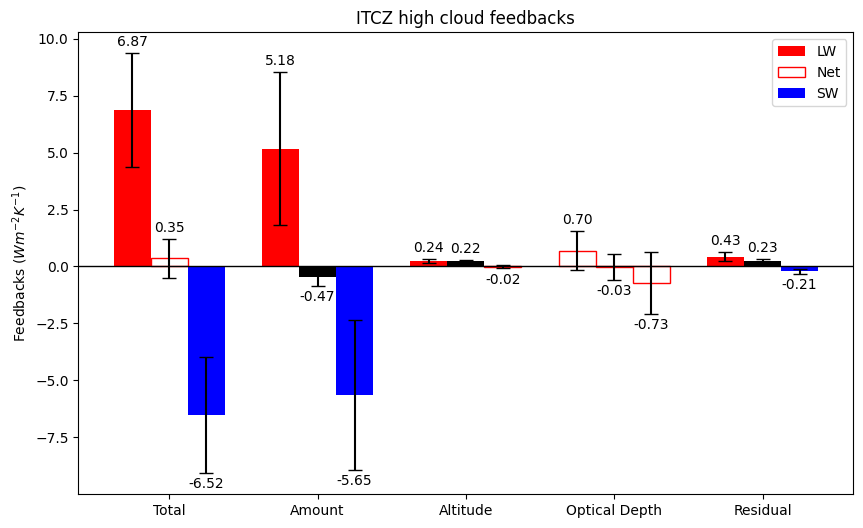

In [48]:
methods.plot(hclw_cp, hcsw_cp, hcnet_cp, area="CP", totallw= (6.8705518072760725 ,2.4877546369137686), totalsw=(-6.518872482955505, 2.5567467982061474), totalnet=(0.35167901589319833, 0.8420146034975553))

# Without ENSO 

In [69]:
(222-179)/222 ,222-(5*12), (222-60)/222 #la data que queda
#222-(5+6+11+8+8+5) 
18/222 #strong

0.08108108108108109

In [72]:
rg24dates = area_ep.time.data

In [73]:
#Strong ONI >1.5
nina0708_s = (np.datetime64('2007-11-15T00:00:00.000000000'), np.datetime64('2008-02-15T00:00:00.000000000' ))
nina1011_s = (np.datetime64('2010-08-15T00:00:00.000000000'), np.datetime64('2010-12-15T00:00:00.000000000' ))
nino1516_s = (np.datetime64('2015-06-15T00:00:00.000000000'), np.datetime64('2016-02-15T00:00:00.000000000' ))

#chatgpt
exclude_s = [nina0708_s, nina1011_s, nino1516_s,]

mask_s = np.ones(rg24dates.shape, dtype=bool)
# Apply the exclusion ranges
for start, end in exclude_s:
    mask_s &= ~((rg24dates >= start) & (rg24dates <= end))

filtered_dates = rg24dates[mask_s]
len(filtered_dates)

204

In [54]:
nino0203 = (np.datetime64('2002-08-15T00:00:00.000000000'), np.datetime64('2002-12-15T00:00:00.000000000' ))
nina0708 = (np.datetime64('2007-08-15T00:00:00.000000000'), np.datetime64('2008-03-15T00:00:00.000000000' ))
nino0910 = (np.datetime64('2009-09-15T00:00:00.000000000'), np.datetime64('2010-02-15T00:00:00.000000000' ))
nina1011 = (np.datetime64('2010-06-15T00:00:00.000000000'), np.datetime64('2011-02-15T00:00:00.000000000' ))
nino1516 = (np.datetime64('2015-05-15T00:00:00.000000000'), np.datetime64('2016-03-15T00:00:00.000000000' ))
nina2021 = (np.datetime64('2020-09-15T00:00:00.000000000'), np.datetime64('2020-12-15T00:00:00.000000000' ))

rg24dates = area_ep.time.data
#chatgpt
exclude = [nino0203, nina0708, nino0910, nina1011, nino1516, nina2021 ]

mask = np.ones(rg24dates.shape, dtype=bool)
# Apply the exclusion ranges
for start, end in exclude:
    mask &= ~((rg24dates >= start) & (rg24dates <= end))

filtered_dates = rg24dates[mask]
len(filtered_dates)

179

In [74]:
gmst2 = gmst.loc[:,['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']].reset_index()
gmst2

,index,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,122,2002,0.77,0.78,0.88,0.58,0.64,0.53,0.61,0.53,0.63,.54,.59,.44
1,123,2003,0.74,0.58,0.60,0.55,0.60,0.48,0.58,0.64,0.62,.72,.53,.75
2,124,2004,0.58,0.72,0.63,0.61,0.37,0.44,0.26,0.45,0.49,.61,.72,.50
3,125,2005,0.74,0.60,0.74,0.67,0.63,0.64,0.61,0.60,0.72,.75,.73,.67
4,126,2006,0.56,0.73,0.63,0.46,0.48,0.66,0.54,0.70,0.66,.70,.74,.79
5,127,2007,1.01,0.70,0.71,0.76,0.68,0.61,0.59,0.60,0.60,.58,.58,.49
6,128,2008,0.30,0.38,0.75,0.54,0.50,0.49,0.60,0.46,0.61,.67,.68,.54
7,129,2009,0.65,0.52,0.53,0.61,0.65,0.64,0.74,0.69,0.71,.65,.79,.67
8,130,2010,0.75,0.83,0.92,0.85,0.75,0.68,0.63,0.67,0.64,.71,.81,.45
9,131,2011,0.52,0.48,0.65,0.64,0.53,0.62,0.70,0.75,0.56,.66,.59,.60


In [75]:
df_long = pd.melt(gmst2.loc[:,['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep','Oct', 'Nov', 'Dec']], id_vars=["Year"], var_name="Month", value_name="Value")
df_long

,Year,Month,Value
0,2002,Jan,0.77
1,2003,Jan,0.74
2,2004,Jan,0.58
3,2005,Jan,0.74
4,2006,Jan,0.56
...,...,...,...
223,2016,Dec,.86
224,2017,Dec,.93
225,2018,Dec,.92
226,2019,Dec,1.11


In [76]:
#df_long[ (df_long.Year==2002) & (df_long.Month=="Jan") ]
#df_long[df_long.Month==("Jan" or "Feb")] 
months_to_remove = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
for month in months_to_remove:
    df_long.drop(df_long[ (df_long.Year==2002) & (df_long.Month==month) ].index, inplace=True)
df_long

,Year,Month,Value
1,2003,Jan,0.74
2,2004,Jan,0.58
3,2005,Jan,0.74
4,2006,Jan,0.56
5,2007,Jan,1.01
...,...,...,...
223,2016,Dec,.86
224,2017,Dec,.93
225,2018,Dec,.92
226,2019,Dec,1.11


In [80]:
df_long["Date"] = pd.to_datetime(df_long.copy()["Year"].astype(str) + df_long.copy()["Month"], format="%Y%b")
df_long

,Year,Month,Value,Date
1,2003,Jan,0.74,2003-01-01
2,2004,Jan,0.58,2004-01-01
3,2005,Jan,0.74,2005-01-01
4,2006,Jan,0.56,2006-01-01
5,2007,Jan,1.01,2007-01-01
...,...,...,...,...
223,2016,Dec,.86,2016-12-01
224,2017,Dec,.93,2017-12-01
225,2018,Dec,.92,2018-12-01
226,2019,Dec,1.11,2019-12-01


In [77]:
ranges_to_exclude = [ (pd.Timestamp('2007-11-01'), pd.Timestamp('2008-02-01' )),
(pd.Timestamp('2010-08-01'), pd.Timestamp('2010-12-01' )),
(pd.Timestamp('2015-06-01'), pd.Timestamp('2016-02-01' )),
]

In [ ]:
ranges_to_exclude = [
(pd.Timestamp('2002-08-01'),pd.Timestamp('2002-12-01' )),
(pd.Timestamp('2007-08-01'),pd.Timestamp('2008-03-01' )),
(pd.Timestamp('2009-09-01'),pd.Timestamp('2010-02-01' )),
(pd.Timestamp('2010-06-01'),pd.Timestamp('2011-02-01' )),
(pd.Timestamp('2015-05-01'),pd.Timestamp('2016-03-01' )),
(pd.Timestamp('2020-09-01'),pd.Timestamp('2020-12-01' )),

]

In [81]:
for start_date, end_date in ranges_to_exclude:
    # Identify indices of rows to drop
    drop_indices = df_long[(df_long["Date"] >= start_date) & (df_long["Date"] <= end_date)].index
    
    # Drop the rows
    df_long = df_long.drop(drop_indices)

In [82]:
df_long

,Year,Month,Value,Date
1,2003,Jan,0.74,2003-01-01
2,2004,Jan,0.58,2004-01-01
3,2005,Jan,0.74,2005-01-01
4,2006,Jan,0.56,2006-01-01
5,2007,Jan,1.01,2007-01-01
...,...,...,...,...
223,2016,Dec,.86,2016-12-01
224,2017,Dec,.93,2017-12-01
225,2018,Dec,.92,2018-12-01
226,2019,Dec,1.11,2019-12-01


In [63]:
ord = df_long.drop(columns=["Date"])
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

In [64]:
ord["Month"] = pd.Categorical(ord["Month"], categories=month_order, ordered=True)

# Pivot to wide format
df_wide = ord.pivot(index="Year", columns="Month", values="Value")

# Ensure calendar order for columns (optional)
df_wide = df_wide[month_order]

# Fill missing values with 0 (optional)
#df_wide = df_wide.fillna(0)

# Reset index if desired
df_wide = df_wide.reset_index()
df_wide

Month,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2002,NaN,NaN,NaN,NaN,NaN,NaN,0.61,0.53,0.63,.54,.59,.44
1,2003,0.74,0.58,0.6,0.55,0.6,0.48,0.58,0.64,0.62,.72,.53,.75
2,2004,0.58,0.72,0.63,0.61,0.37,0.44,0.26,0.45,0.49,.61,.72,.50
3,2005,0.74,0.6,0.74,0.67,0.63,0.64,0.61,0.6,0.72,.75,.73,.67
4,2006,0.56,0.73,0.63,0.46,0.48,0.66,0.54,0.7,0.66,.70,.74,.79
5,2007,1.01,0.7,0.71,0.76,0.68,0.61,0.59,0.6,0.6,.58,NaN,NaN
6,2008,NaN,NaN,0.75,0.54,0.5,0.49,0.6,0.46,0.61,.67,.68,.54
7,2009,0.65,0.52,0.53,0.61,0.65,0.64,0.74,0.69,0.71,.65,.79,.67
8,2010,0.75,0.83,0.92,0.85,0.75,0.68,0.63,NaN,NaN,NaN,NaN,NaN
9,2011,0.52,0.48,0.65,0.64,0.53,0.62,0.7,0.75,0.56,.66,.59,.60


In [83]:
gmst_anom_noenso = df_long.Value.to_list()
gmst_anom_noenso = np.array(gmst_anom_noenso, dtype=np.float16)
type(gmst_anom_noenso[0] )#K_wp
#stats.linregress(gmst, bints)

numpy.float16

## WP

In [ ]:
#sel press antes o despues de mean lon? puede ser causa del error
area_wp = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=wp,time=filtered_dates).mean("lon")

RclrLW_wp = alllw.sel(lat=itcz,lon=wp, time=filtered_dates).toa_lw_clr_mon.mean("lon")
RovcLW_wp = alllw.sel(lat=itcz,lon=wp, time=filtered_dates).toa_lw_cldtyp_mon.mean("lon")
lwK_wp = (RclrLW_wp - RovcLW_wp)/100

RclrSW_wp = allsw.sel(lat=itcz,lon=wp, time=filtered_dates).toa_sw_clr_mon.mean("lon")
RovcSW_wp = allsw.sel(lat=itcz,lon=wp, time=filtered_dates).toa_sw_cldtyp_mon.mean("lon")
swK_wp = (RclrSW_wp - RovcSW_wp)/100

K_wp = lwK_wp + swK_wp

In [ ]:
feed_wp = total_feedback(area_wp, K_wp, gmst_anom_noenso)
print(feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)
#feed_wp[0].plot()

feed_wp = total_feedback(area_wp, swK_wp, gmst_anom_noenso)
print(feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_wp = total_feedback(area_wp, lwK_wp, gmst_anom_noenso)
print(feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

0.08198975818994433 0.985385145124428
-0.01391505044846586 3.379339369760112
0.09590458549380436 3.1804808620007465


In [ ]:
hclw_wp = methods.Feedbacks(area_wp.sel(press=[4,5,6]), lwK_wp.sel(press=[4,5,6]), gmst_anom_noenso)
hcsw_wp = methods.Feedbacks(area_wp.sel(press=[4,5,6]), swK_wp.sel(press=[4,5,6]), gmst_anom_noenso)
hcnet_wp = methods.Feedbacks(area_wp.sel(press=[4,5,6]), K_wp.sel(press=[4,5,6]), gmst_anom_noenso)

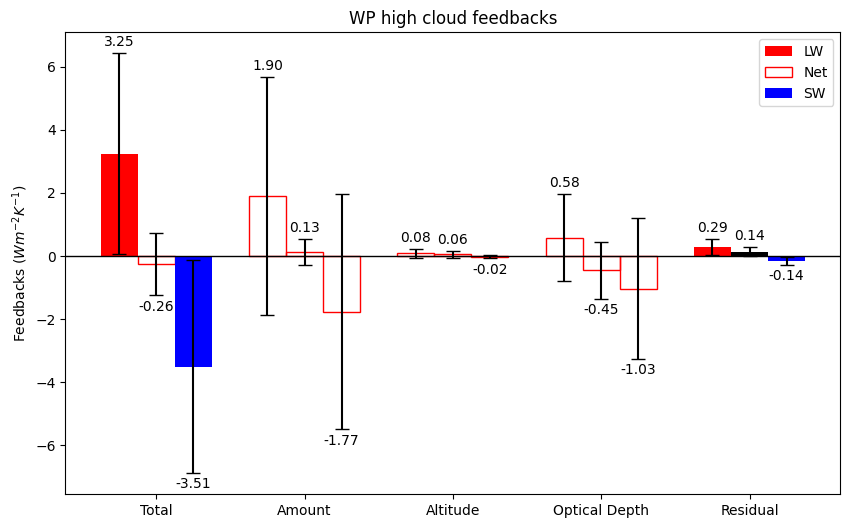

In [ ]:
methods.plot(hclw_wp, hcsw_wp, hcnet_wp, area="WP", totallw= (3.2451192573506122, 3.1804808620007465), totalsw=(-3.5067620590855, 3.379339369760112), totalnet=(-0.2616512168035753, 0.985385145124428) )

#whole enso years: methods.plot(hclw_wp, hcsw_wp, hcnet_wp, totallw= (-0.5818308824114647, 3.404410832732528), totalsw=(0.6226261443680257, 3.57531942008397), totalnet=(0.040799869783581806, 1.041954306184636) )

In [ ]:
#Without strong events
methods.summary(hclw_wp, hcsw_wp, hcnet_wp, totallw= (3.2451192573506122, 3.1804808620007465), totalsw=(-3.5067620590855, 3.379339369760112), totalnet=(-0.2616512168035753, 0.985385145124428))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,3.2451,3.1805,-3.5068,3.3793,-0.2617,0.9854
Amount,1.8992,3.7639,-1.7702,3.7274,0.1289,0.4188
Altitude,0.0814,0.1524,-0.0233,0.0492,0.0580,0.1125
Optical Depth,0.5811,1.3798,-1.0310,2.2416,-0.4493,0.8981
Residual,0.2860,0.2548,-0.1437,0.1257,0.1419,0.1416


### Legacy

In [ ]:
#Net
a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), K_wp.sel(press=[4,5,6]), gmst_anom_noenso)

b_ITCZ = hc_feedbacks(area_wp, K_wp, "press", sst_anom=gmst_anom_noenso)

c_ITCZ = hc_feedbacks(area_wp, K_wp, "opt", sst_anom=gmst_anom_noenso)

res_reg =  res_feedbacks(area_wp, K_wp, gmst_anom_noenso)
res_ITCZ = res_reg.slope

hc_tot = feed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data
print(f"{hc_tot[0]},  {a_ITCZ[0]},{b_ITCZ[0]},{c_ITCZ[0]},{res_ITCZ}") 

# Confidence interval
ci_a =  a_ITCZ[1] #amount
ci_b =  b_ITCZ[1] #press
ci_c =  c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{hc_tot[1]}, {ci_a}, {ci_b} , {ci_c}, {ci_res}")

-0.05147356135663909,  0.4684230330730272,-0.15021052348802238,-0.26730115616258965,0.10496978238232695
1.0052416948163094, 0.44694328204923933, 0.11983575443368015 , 0.9754869803218177, 0.15208791704662789


0.34770289190638626


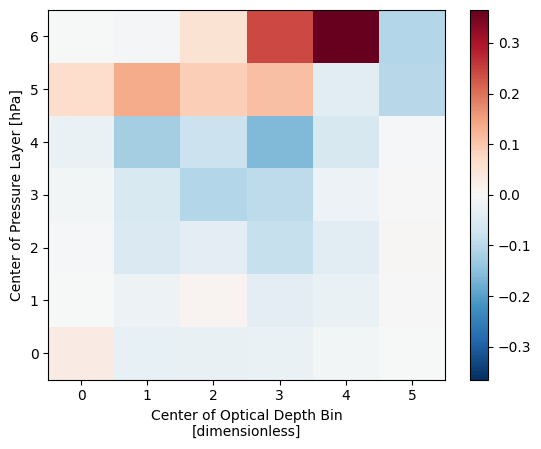

In [ ]:
swfeed_wp = total_feedback(area_wp, swK_wp, gmst_anom_noenso)
print(swfeed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data)
swfeed_wp[0].plot()

In [ ]:
#SW

a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), swK_wp.sel(press=[4,5,6]), gmst_anom_noenso)

b_ITCZ = hc_feedbacks(area_wp, swK_wp, "press", gmst_anom_noenso)

c_ITCZ = hc_feedbacks(area_wp, swK_wp, "opt", gmst_anom_noenso)

res_reg =  res_feedbacks(area_wp, swK_wp, gmst_anom_noenso)
res_ITCZ = res_reg.slope

hc_tot = swfeed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, swfeed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data
print(f"{hc_tot[0]},  {a_ITCZ[0]},{b_ITCZ[0]},{c_ITCZ[0]},{res_ITCZ}") 

# Confidence interval
ci_a = a_ITCZ[1] #amount
ci_b = b_ITCZ[1] #press
ci_c = c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{hc_tot[1]}, {ci_a}, {ci_b} , {ci_c}, {ci_res}")

0.34770289190638626,  1.191735485756887,0.03689889164994543,-0.8185329776573541,-0.018849798963848828
3.43693766348895, 4.048672266615159, 0.05113338756163577 , 2.3723452437739474, 0.11730255280491


-0.3991806860843852


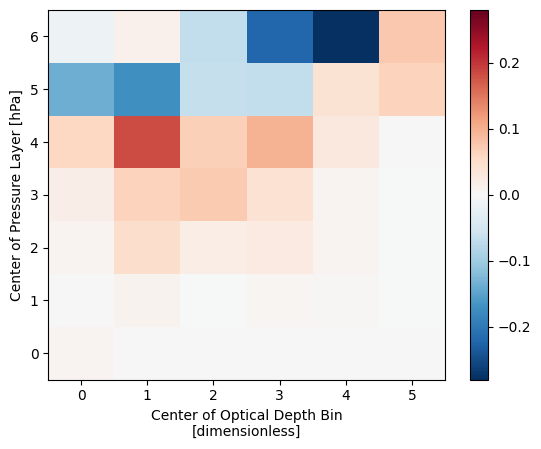

In [ ]:
lwfeed_wp = total_feedback(area_wp, lwK_wp, gmst_anom_noenso)
print(lwfeed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data)
lwfeed_wp[0].plot()

In [ ]:
#LW
a_ITCZ = feedback_amount(area_wp.sel(press=[4,5,6]), lwK_wp.sel(press=[4,5,6]), gmst_anom_noenso)

b_ITCZ = hc_feedbacks(area_wp, lwK_wp, "press", gmst_anom_noenso)

c_ITCZ = hc_feedbacks(area_wp, lwK_wp, "opt", gmst_anom_noenso)

res_reg =  res_feedbacks(area_wp, lwK_wp, gmst_anom_noenso)
res_ITCZ = res_reg.slope

hc_tot = lwfeed_wp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, lwfeed_wp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data
print(f"{hc_tot[0]},  {a_ITCZ[0]},{b_ITCZ[0]},{c_ITCZ[0]},{res_ITCZ}") 

# Confidence interval
ci_a = a_ITCZ[1] #amount
ci_b = b_ITCZ[1] #press
ci_c = c_ITCZ[1] #opt
ci_res = ts*res_reg.stderr
print(f"{hc_tot[1]}, {ci_a}, {ci_b} , {ci_c}, {ci_res}")

-0.3991806860843852,  -0.7233123212492535,-0.18713412059797233,0.5513955200033084,0.12368432508524468
3.2585098820495406, 4.069394195002268, 0.1596765977181596 , 1.4377664531494252, 0.2584293228909438


In [ ]:
decompos = ("Total", "Amount", "Altitude", "Optical Depth", "Residual")
feeds_wp = { #los del costadfo estaban mal porque calcule con uno del ep la lw
    'LW': (-0.3991806860843852,  -0.7233123212492535,-0.18713412059797233,0.5513955200033084,0.12368432508524468),
    'Net': (-0.05147356135663909,  0.4684230330730272,-0.15021052348802238,-0.26730115616258965,0.10496978238232695),#OD CHANGES, IS 1.2 in enso included, los otros son casi iguales
    'SW': (0.34770289190638626,  1.191735485756887,0.03689889164994543,-0.8185329776573541,-0.0188497989638488288), #10.773349440568133, 7.6657906563413585, -0.04592645383388778, 2.9055360005624027, 0.24794923749825948
}

colors = {
    'LW': 'red',
    'Net': 'black',
    'SW': 'blue'
}

ci_upper = {
    'LW': feeds_wp["LW"] + np.array([3.2585098820495406, 4.069394195002268, 0.1596765977181596 , 1.4377664531494252, 0.2584293228909438]),
    'Net': feeds_wp["Net"] + np.array([1.0052416948163094, 0.44602626418891944, 0.11958988089326862 , 0.9734855205854431, 0.15208791704662789]), 
    'SW': feeds_wp["SW"] + np.array([3.43693766348895, 4.048672266615159, 0.05113338756163577 , 2.3723452437739474, 0.11730255280491]),
}
ci_lower = {
    'LW': feeds_wp["LW"] - np.array([3.2585098820495406, 4.069394195002268, 0.1596765977181596 , 1.4377664531494252, 0.2584293228909438]),
    'Net': feeds_wp["Net"] - np.array([1.0052416948163094, 0.44602626418891944, 0.11958988089326862 , 0.9734855205854431, 0.15208791704662789]),
    'SW': feeds_wp["SW"] -np.array([3.43693766348895, 4.048672266615159, 0.05113338756163577 , 2.3723452437739474, 0.11730255280491]),
}

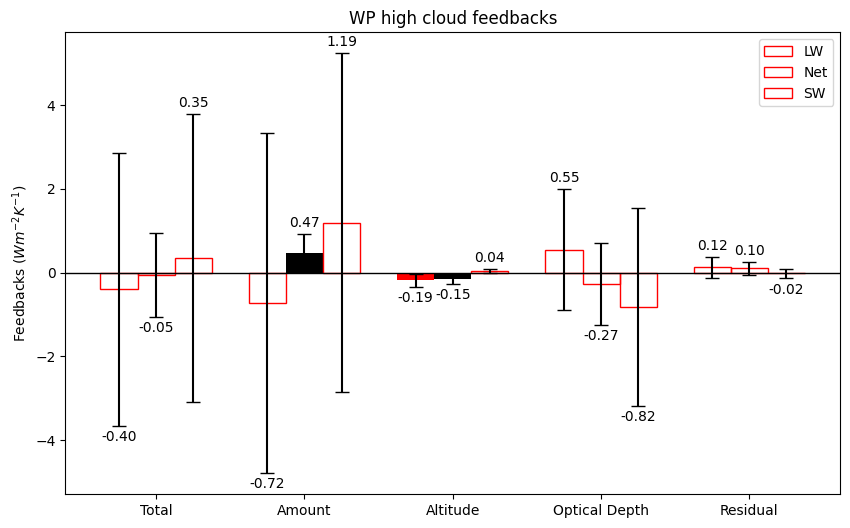

In [ ]:
x = np.arange(len(decompos))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10,6))

for attribute, measurement in feeds_wp.items():
    offset = width * multiplier

    # Calculate asymmetric error bars
    lower_errors = [m - ci for m, ci in zip(measurement, ci_lower[attribute])]
    upper_errors = [ci - m for m, ci in zip(measurement, ci_upper[attribute])]
    yerr_values = (lower_errors, upper_errors)

    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=yerr_values, capsize=5, color=colors[attribute]) 

    for i, rect in enumerate(rects):
        lower_bound = ci_lower[attribute][i]
        upper_bound = ci_upper[attribute][i]
    
        if lower_bound <= 0 <= upper_bound:  # Not significant # Only apply to LW bars
            rect.set_facecolor('none')  # Remove filling for the first bar
            rect.set_edgecolor('red')

    ax.bar_label(rects, labels=[f"{value:.2f}" for value in measurement], padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'Feedbacks ($Wm^{-2}K^{-1}$)')
ax.set_title('WP high cloud feedbacks')
ax.legend(loc='upper right')
ax.set_xticks(x + width)
ax.set_xticklabels(["Total", "Amount", "Altitude", "Optical Depth", "Residual"])
ax.axhline(0, color="black", linewidth=1)

plt.show()

## EP

In [ ]:
area_ep = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=ep,time=filtered_dates).mean("lon")

RclrLW_ep = alllw.sel(lat=itcz,lon=ep, time=filtered_dates).toa_lw_clr_mon.mean("lon")
RovcLW_ep = alllw.sel(lat=itcz,lon=ep, time=filtered_dates).toa_lw_cldtyp_mon.mean("lon")
lwK_ep = (RclrLW_ep - RovcLW_ep)/100

RclrSW_ep = allsw.sel(lat=itcz,lon=ep, time=filtered_dates).toa_sw_clr_mon.mean("lon")
RovcSW_ep = allsw.sel(lat=itcz,lon=ep, time=filtered_dates).toa_sw_cldtyp_mon.mean("lon")
swK_ep = (RclrSW_ep - RovcSW_ep)/100

K_ep = lwK_ep + swK_ep

In [ ]:
feed_ep = total_feedback(area_ep, K_ep, gmst_anom_noenso)
print(feed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_ep[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_ep = total_feedback(area_ep, swK_ep, gmst_anom_noenso)
print(feed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_ep[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_ep = total_feedback(area_ep, lwK_ep, gmst_anom_noenso)
print(feed_ep[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_ep[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

0.054923286344610515 0.5763093281065931
1.021740944201998 1.886557258691749
-0.9668182414528358 1.6303233191073052


In [ ]:
hclw_ep = methods.Feedbacks(area_ep.sel(press=[4,5,6]), lwK_ep.sel(press=[4,5,6]), gmst_anom_noenso)
hcsw_ep = methods.Feedbacks(area_ep.sel(press=[4,5,6]), swK_ep.sel(press=[4,5,6]), gmst_anom_noenso)
hcnet_ep = methods.Feedbacks(area_ep.sel(press=[4,5,6]), K_ep.sel(press=[4,5,6]), gmst_anom_noenso)

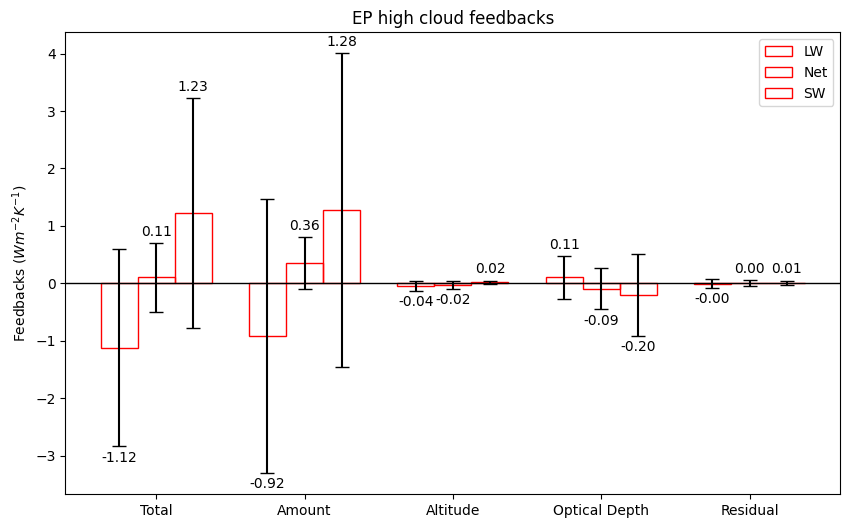

In [ ]:
methods.plot(hclw_ep, hcsw_ep, hcnet_ep, area="EP", totallw= (-1.1187773025480285, 1.722653773437394), totalsw=(1.2280957872534204, 2.005889264178344), totalnet=(0.10588325004014744, 0.6) )
#whole year methods.plot(hclw_ep, hcsw_ep, hcnet_ep, totallw= (-3.3359436365689716, 1.9290434640101772), totalsw=(4.008472902815475, 2.2344610810579137), totalnet=(0.6725290822893096, 0.6716756040856816) )

In [ ]:
methods.summary(hclw_ep, hcsw_ep, hcnet_ep, totallw= (-1.1187773025480285, 1.722653773437394), totalsw=(1.2280957872534204, 2.005889264178344), totalnet=(0.10588325004014744, 0.6))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,-1.1188,1.7227,1.2281,2.0059,0.1059,0.6000
Amount,-0.9200,2.3883,1.2767,2.7300,0.3567,0.4516
Altitude,-0.0425,0.0875,0.0199,0.0288,-0.0227,0.0713
Optical Depth,0.1082,0.3734,-0.2028,0.7083,-0.0945,0.3592
Residual,-0.0038,0.0767,0.0083,0.0404,0.0046,0.0531


## CP

In [84]:
#sel press antes o despues de mean lon? puede ser causa del error
area_cp = alllw.cldarea_cldtyp_mon.sel(lat=itcz, lon=cp,time=filtered_dates).mean("lon")

RclrLW_cp = alllw.sel(lat=itcz,lon=cp, time=filtered_dates).toa_lw_clr_mon.mean("lon")
RovcLW_cp = alllw.sel(lat=itcz,lon=cp, time=filtered_dates).toa_lw_cldtyp_mon.mean("lon")
lwK_cp = (RclrLW_cp - RovcLW_cp)/100

RclrSW_cp = allsw.sel(lat=itcz,lon=cp, time=filtered_dates).toa_sw_clr_mon.mean("lon")
RovcSW_cp = allsw.sel(lat=itcz,lon=cp, time=filtered_dates).toa_sw_cldtyp_mon.mean("lon")
swK_cp = (RclrSW_cp - RovcSW_cp)/100

K_cp = lwK_cp + swK_cp

In [87]:
feed_cp = total_feedback(area_cp, K_cp, gmst_anom_noenso)
print(feed_cp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data,",", feed_cp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_cp = total_feedback(area_cp, swK_cp, gmst_anom_noenso)
print(feed_cp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data,",", feed_cp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_cp = total_feedback(area_cp, lwK_cp, gmst_anom_noenso)
print(feed_cp[0].sel(press=[4,5,6]).sum(["press", "opt"]).data,",", feed_cp[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

0.434952505363653 , 0.9188232180014728
-1.749380147571398 , 2.792109784681752
2.184332457178337 , 2.7030717706565204


In [89]:
hclw_cp = methods.Feedbacks(area_cp.sel(press=[4,5,6]), lwK_cp.sel(press=[4,5,6]), gmst_anom_noenso)
hcsw_cp = methods.Feedbacks(area_cp.sel(press=[4,5,6]), swK_cp.sel(press=[4,5,6]), gmst_anom_noenso)
hcnet_cp = methods.Feedbacks(area_cp.sel(press=[4,5,6]), K_cp.sel(press=[4,5,6]), gmst_anom_noenso)

In [90]:
methods.summary(hclw_cp, hcsw_cp, hcnet_cp, totallw= (2.184332457178337, 2.7030717706565204), totalsw=(-1.749380147571398 , 2.792109784681752), totalnet=(0.434952505363653 , 0.9188232180014728))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,2.1843,2.7031,-1.7494,2.7921,0.4350,0.9188
Amount,1.9951,3.6077,-1.5267,3.5442,0.4684,0.4363
Altitude,0.0639,0.1107,-0.0459,0.0718,0.0179,0.0804
Optical Depth,0.0205,0.9163,-0.0100,1.4497,0.0104,0.6160
Residual,0.1606,0.2031,-0.0907,0.1120,0.0699,0.1250


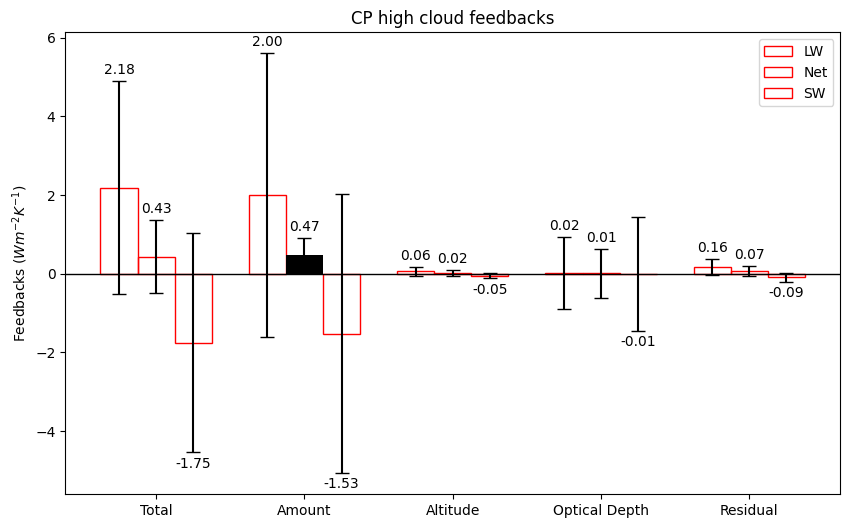

In [92]:

methods.plot(hclw_cp, hcsw_cp, hcnet_cp,area="CP", totallw= (2.184332457178337, 2.7030717706565204), totalsw=(-1.749380147571398 , 2.792109784681752), totalnet=(0.434952505363653 , 0.9188232180014728))

## ITCZ

In [ ]:
area_itcz = alllw.cldarea_cldtyp_mon.sel(lat=itcz, time=filtered_dates).mean("lon")

RclrLW_itcz = alllw.sel(lat=itcz,lon=ocean_only, time=filtered_dates).toa_lw_clr_mon.mean("lon")
RovcLW_itcz = alllw.sel(lat=itcz,lon=ocean_only, time=filtered_dates).toa_lw_cldtyp_mon.mean("lon")
lwK_itcz = (RclrLW_itcz - RovcLW_itcz)/100

RclrSW_itcz = allsw.sel(lat=itcz,lon=ocean_only,time=filtered_dates).toa_sw_clr_mon.mean("lon")
RovcSW_itcz = allsw.sel(lat=itcz,lon=ocean_only,time=filtered_dates).toa_sw_cldtyp_mon.mean("lon")
swK_itcz = (RclrSW_itcz - RovcSW_itcz)/100

K_itcz = lwK_itcz + swK_itcz

In [ ]:
feed_itcz = total_feedback(area_itcz, K_itcz, gmst_anom_noenso)
print(feed_itcz[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_itcz[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_itcz = total_feedback(area_itcz, swK_itcz, gmst_anom_noenso)
print(feed_itcz[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_itcz[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_itcz = total_feedback(area_itcz, lwK_itcz, gmst_anom_noenso)
print(feed_itcz[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_itcz[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

0.0029592252200935226 0.23189748534007398
-0.38862505797131225 0.7153668277529673
0.39158435318300905 0.6730834293489718


In [ ]:
hclw_itcz = methods.Feedbacks(area_itcz.sel(press=[4,5,6]), lwK_itcz.sel(press=[4,5,6]), gmst_anom_noenso)
hcsw_itcz = methods.Feedbacks(area_itcz.sel(press=[4,5,6]), swK_itcz.sel(press=[4,5,6]), gmst_anom_noenso)
hcnet_itcz = methods.Feedbacks(area_itcz.sel(press=[4,5,6]), K_itcz.sel(press=[4,5,6]), gmst_anom_noenso)

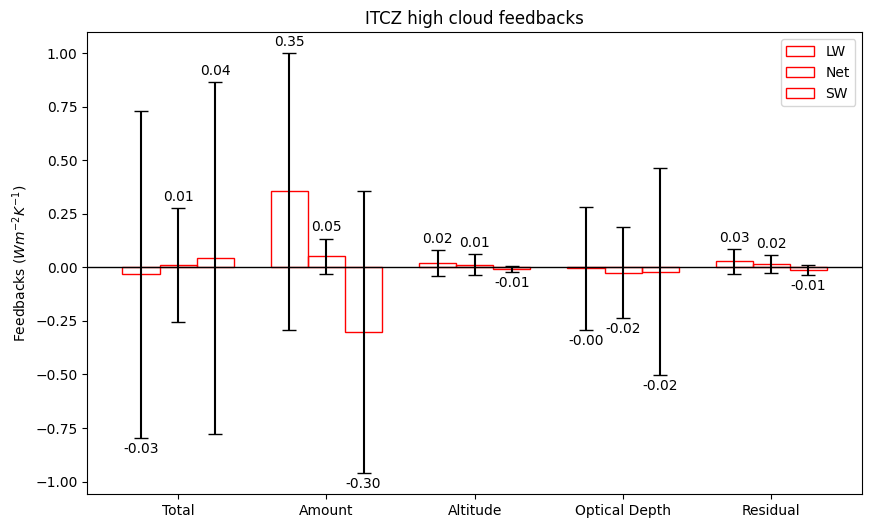

In [ ]:
methods.plot(hclw_itcz, hcsw_itcz, hcnet_itcz, totallw= (-0.03295189051264917, 0.7647583064623364), totalsw=(0.043291378241905265, 0.820233315010817), totalnet=(0.01033944715053441 ,0.26632905333957263))

#wholeyear methods.plot(hclw_itcz, hcsw_itcz, hcnet_itcz, totallw= (0.09256827739778067, 0.7769990159301117), totalsw=(-0.2631880502171322, 0.825206700401199), totalnet=(-0.17061972937407596, 0.2707956997866036) )

In [ ]:
methods.summary(hclw_itcz, hcsw_itcz, hcnet_itcz, totallw= (-0.03295189051264917, 0.7647583064623364), totalsw=(0.043291378241905265, 0.820233315010817), totalnet=(0.01033944715053441 ,0.26632905333957263))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,-0.0330,0.7648,0.0433,0.8202,0.0103,0.2663
Amount,0.3545,0.6450,-0.3026,0.6586,0.0520,0.0825
Altitude,0.0194,0.0605,-0.0068,0.0149,0.0126,0.0478
Optical Depth,-0.0049,0.2851,-0.0196,0.4840,-0.0246,0.2130
Residual,0.0278,0.0594,-0.0126,0.0221,0.0152,0.0432


## Tropics

In [ ]:
area_trop = alllw.cldarea_cldtyp_mon.sel( time=filtered_dates).mean("lon")

RclrLW_trop = alllw.sel(time=filtered_dates).toa_lw_clr_mon.mean("lon")
RovcLW_trop = alllw.sel(time=filtered_dates).toa_lw_cldtyp_mon.mean("lon")
lwK_trop = (RclrLW_trop - RovcLW_trop)/100

RclrSW_trop = allsw.sel(time=filtered_dates).toa_sw_clr_mon.mean("lon")
RovcSW_trop = allsw.sel(time=filtered_dates).toa_sw_cldtyp_mon.mean("lon")
swK_trop = (RclrSW_trop - RovcSW_trop)/100

K_trop = lwK_trop + swK_trop

In [ ]:
feed_trop = total_feedback(area_trop, K_trop, gmst_anom_noenso)
print(feed_trop[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_trop[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_trop = total_feedback(area_trop, swK_trop, gmst_anom_noenso)
print(feed_trop[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_trop[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

feed_trop = total_feedback(area_trop, lwK_trop, gmst_anom_noenso)
print(feed_trop[0].sel(press=[4,5,6]).sum(["press", "opt"]).data, feed_trop[1].sel(press=[4,5,6]).sum(["press", "opt"]).data)

-0.0014611848687774024 0.13139856324310317
0.005502194858925901 0.36466542899790305
-0.006964244465670878 0.37677265696670137


In [ ]:
hclw_trop = methods.Feedbacks(area_trop.sel(press=[4,5,6]), lwK_trop.sel(press=[4,5,6]), gmst_anom_noenso)
hcsw_trop = methods.Feedbacks(area_trop.sel(press=[4,5,6]), swK_trop.sel(press=[4,5,6]), gmst_anom_noenso)
hcnet_trop = methods.Feedbacks(area_trop.sel(press=[4,5,6]), K_trop.sel(press=[4,5,6]), gmst_anom_noenso)

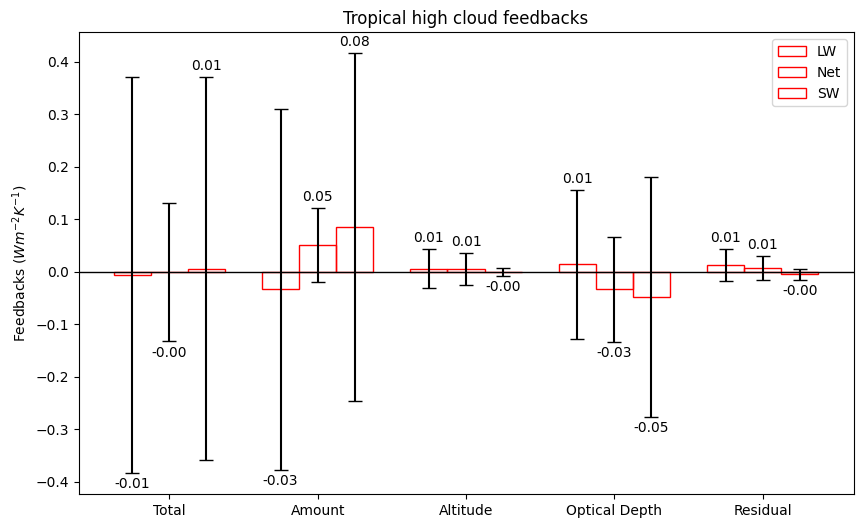

In [ ]:
#Strong: total changes much, but not its ci's
methods.plot(hclw_trop, hcsw_trop, hcnet_trop, area="Tropical", totallw= (-0.006964244465670878, 0.37677265696670137), totalsw=(0.005502194858925901, 0.36466542899790305), totalnet=(-0.0014611848687774024, 0.13139856324310317) ) #ylim = (-0.8,0.8)

#only specific months 
#methods.plot(hclw_trop, hcsw_trop, hcnet_trop, area="Tropical", totallw= (-0.32144056048948605, 0.40637179899596637), totalsw=(0.25593770063077453, 0.39347230094077945), totalnet=(-0.06550202543012507, 0.1419537350647238) )

#wholeyear methods.plot(hclw_trop, hcsw_trop, hcnet_trop, totallw= (-0.27048012138227223, 0.4178396528364858), totalsw=(0.14195131307017997, 0.4069360346284631), totalnet=(-0.1285290531682716, 0.14743967170683625) )

In [ ]:
#Moderate
methods.summary(hclw_trop, hcsw_trop, hcnet_trop, totallw= (-0.32144056048948605, 0.40637179899596637), totalsw=(0.25593770063077453, 0.39347230094077945), totalnet=(-0.06550202543012507, 0.1419537350647238) )

#Only strong events
#methods.summary(hclw_trop, hcsw_trop, hcnet_trop, totallw= (-0.006964244465670878, 0.37677265696670137), totalsw=(0.005502194858925901, 0.36466542899790305), totalnet=(-0.0014611848687774024, 0.13139856324310317))

,lw_mean,lw_ci,sw_mean,sw_ci,net_mean,net_ci
Total,-0.3214,0.4064,0.2559,0.3935,-0.0655,0.1420
Amount,-0.2798,0.3782,0.2230,0.3612,-0.0567,0.0755
Altitude,0.0059,0.0412,-0.0019,0.0083,0.0040,0.0340
Optical Depth,-0.0444,0.1505,0.0162,0.2471,-0.0282,0.1098
Residual,0.0027,0.0320,-0.0001,0.0108,0.0025,0.0243


# Multilinear regression 

In [ ]:
import statsmodels.api as sm

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results